# Eye State Prediction using EEG Data

  - This project is to determine whether a person's eyes are open or closed using Electroencephalography(EEG) measurements.

      - Datasets are provided in two formats '.arff' and '.csv'.
      - The data contains 14 variables of EEG measurement results and eye state.
      - The data is obtained in one continuous measurement for 117 seconds.
      - Eye state is recorded in binary, where 1 means open and 0 means closed.
      - [More info](https://www.kaggle.com/datasets/robikscube/eye-state-classification-eeg-dataset)

## The Problem
We have some data coming from one continuous EEG (i.e. Electroencephalogram measurement with the Emotiv EEG neuroheadset which  is this device below:

Now, in the dataset we're about to explore, we have the measures for all these points (except CMS and DRL):

   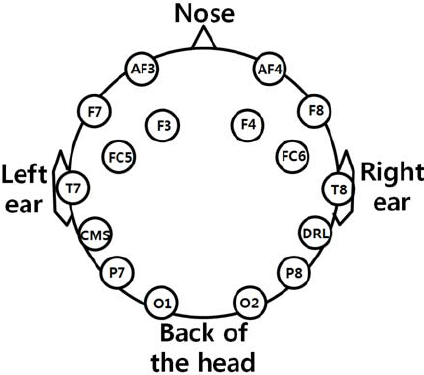
   
We also have the indication of the open state of the eye which will be our target value. Because we will try to train a nice model which can predict depending of the measurements points if the eye is opened or not.


### Importing Libraries


In [20]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy

from itertools import cycle
from scipy import stats
from scipy.stats import norm
from sklearn.decomposition import FastICA
from scipy.signal import welch

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
#!pip install termcolor

from termcolor import colored
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.style.use("fivethirtyeight")


### Loading Data   

In [21]:
df = pd.read_csv('C:/Monitors_EEG_Classification/EEG_Eye_State_Classification.csv')

df.head(2)

AF3       F7       F3      FC5       T7       P7       O1       O2  \
0  4329.23  4009.23  4289.23  4148.21  4350.26  4586.15  4096.92  4641.03   
1  4324.62  4004.62  4293.85  4148.72  4342.05  4586.67  4097.44  4638.97   

        P8       T8      FC6       F4       F8      AF4  eyeDetection  
0  4222.05  4238.46  4211.28  4280.51  4635.90  4393.85             0  
1  4210.77  4226.67  4207.69  4279.49  4632.82  4384.10             0

###  Exploratory Data Analysis (EDA) 📊

In [22]:
print(df.shape)
print(colored("Shape of the dataset:", "green", attrs=['bold', 'underline']))
print(colored(f"\t{df.shape[0]} rows", "green"))
print(colored(f"\t{df.shape[1]} columns", "green"))

(14980, 15)
Shape of the dataset:
	14980 rows
	15 columns


In [23]:
df.describe()

AF3            F7            F3            FC5            T7  \
count   14980.000000  14980.000000  14980.000000   14980.000000  14980.000000   
mean     4321.917777   4009.767694   4264.022433    4164.946326   4341.741075   
std      2492.072174     45.941672     44.428052    5216.404632     34.738821   
min      1030.770000   2830.770000   1040.000000    2453.330000   2089.740000   
25%      4280.510000   3990.770000   4250.260000    4108.210000   4331.790000   
50%      4294.360000   4005.640000   4262.560000    4120.510000   4338.970000   
75%      4311.790000   4023.080000   4270.770000    4132.310000   4347.180000   
max    309231.000000   7804.620000   6880.510000  642564.000000   6474.360000   

                  P7             O1            O2             P8  \
count   14980.000000   14980.000000  14980.000000   14980.000000   
mean     4644.022379    4110.400160   4616.056904    4218.826610   
std      2924.789537    4600.926543     29.292603    2136.408523   
min      2768.210000    2086.150000   4567.180000    1357.950000   
25%      4611.790000    4057.950000   4604.620000    4190.770000   
50%      4617.950000    4070.260000   4613.330000    4199.490000   
75%      4626.670000    4083.590000   4624.100000    4209.230000   
max    362564.000000  567179.000000   7264.100000  265641.000000   

                 T8           FC6            F4             F8            AF4  \
count  14980.000000  14980.000000  14980.000000   14980.000000   14980.000000   
mean    4231.316200   4202.456900   4279.232774    4615.205336    4416.435832   
std       38.050903     37.785981     41.544312    1208.369958    5891.285043   
min     1816.410000   3273.330000   2257.950000      86.666700    1366.150000   
25%     4220.510000   4190.260000   4267.690000    4590.770000    4342.050000   
50%     4229.230000   4200.510000   4276.920000    4603.080000    4354.870000   
75%     4239.490000   4211.280000   4287.180000    4617.440000    4372.820000   
max     6674.360000   6823.080000   7002.560000  152308.000000  715897.000000   

       eyeDetection  
count  14980.000000  
mean       0.448798  
std        0.497388  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


In [27]:
df.isnull().sum()   #check null values

AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64

In [28]:
df['eyeDetection'].value_counts()

eyeDetection
0    8257
1    6723
Name: count, dtype: int64

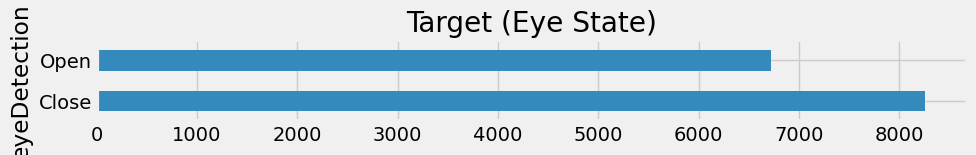

In [29]:
# Display Target 
df['eyeDetection'].value_counts().plot(kind='barh',
                                       title='Target (Eye State)',
                                       figsize=(10, 1),
                                       color=color_pal[0],
                                      )
plt.yticks([0, 1],['Close','Open'])
plt.show()

Text(0.5, 1.0, 'Target distribution')

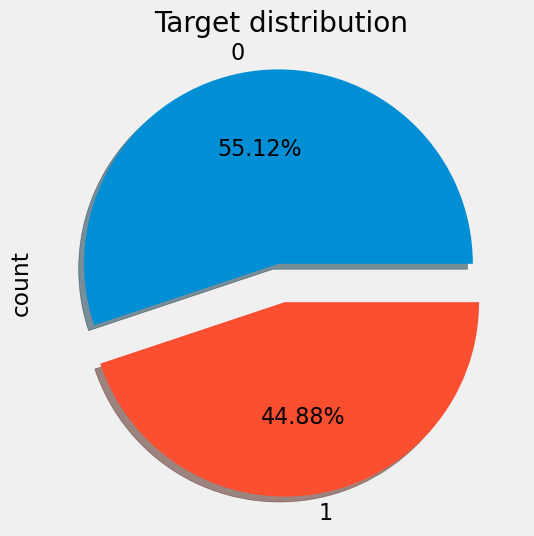

In [31]:
# Plotting target distribution 
plt.figure(figsize=(6,6))
df['eyeDetection'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.2f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

#### Visualize some features aligned with the target variable (eyeDetection)¶


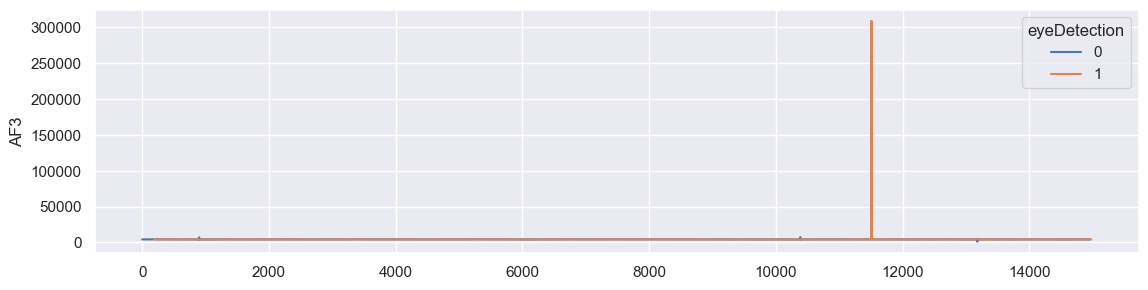

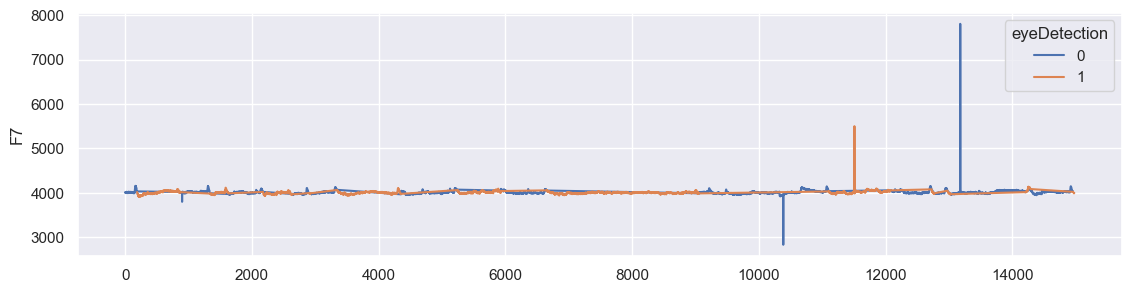

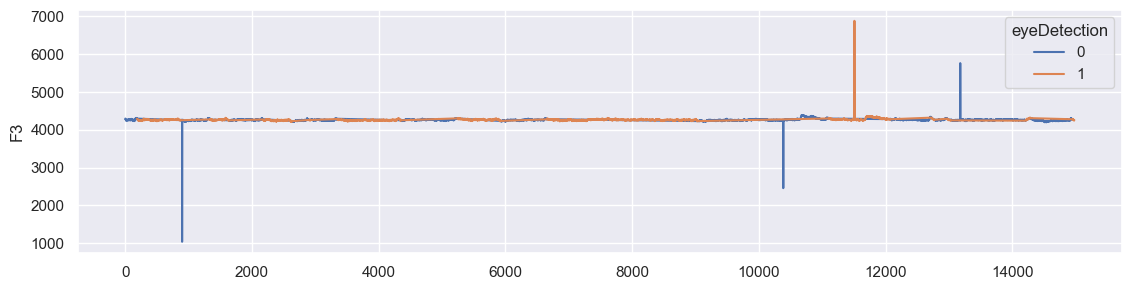

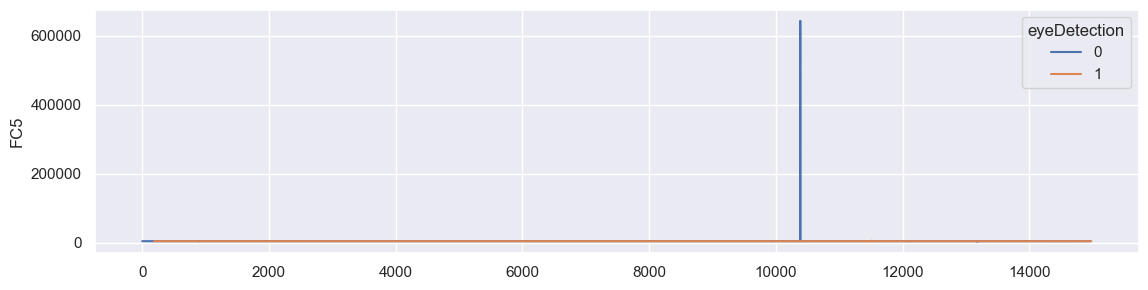

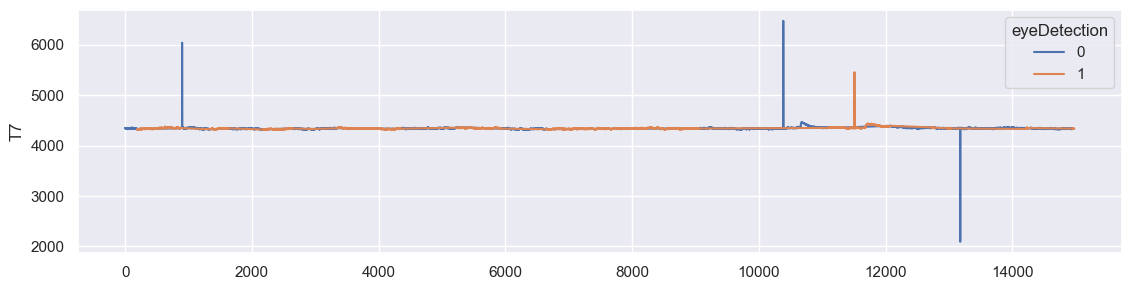

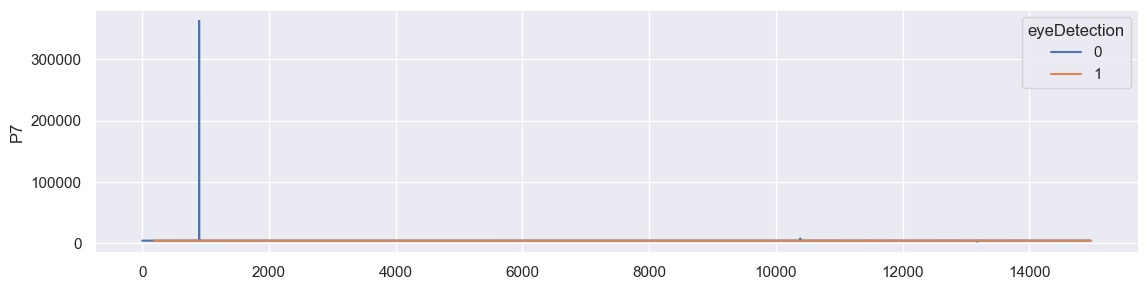

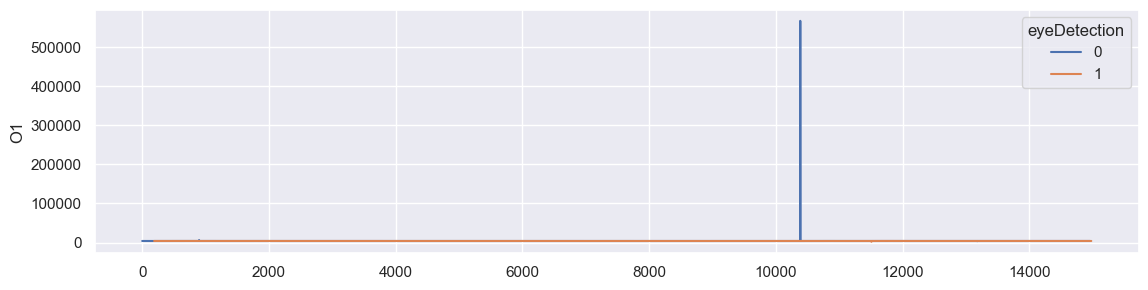

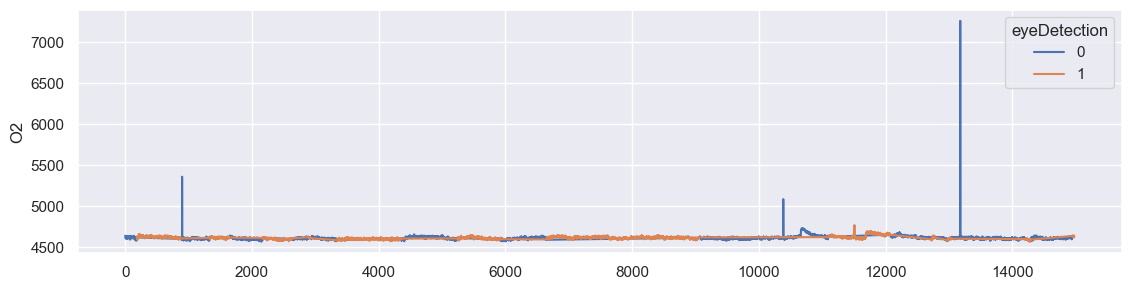

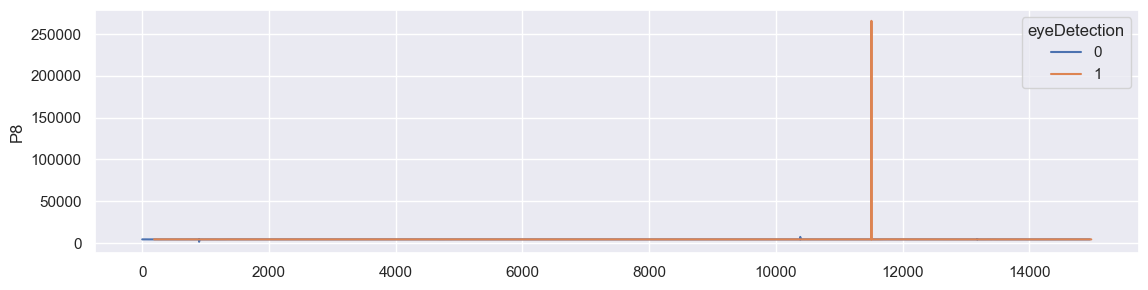

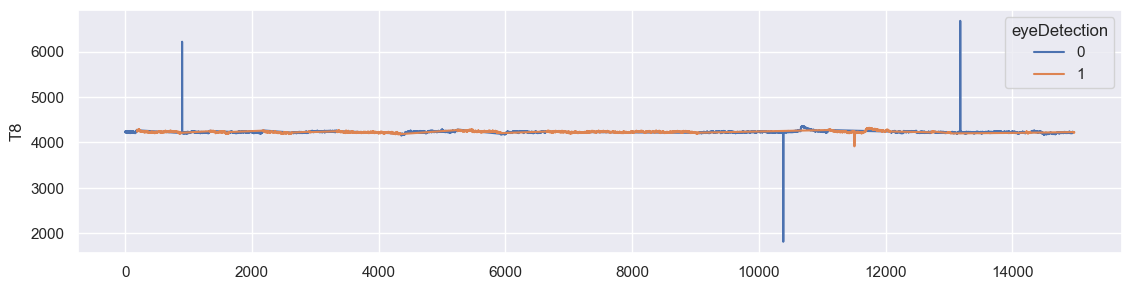

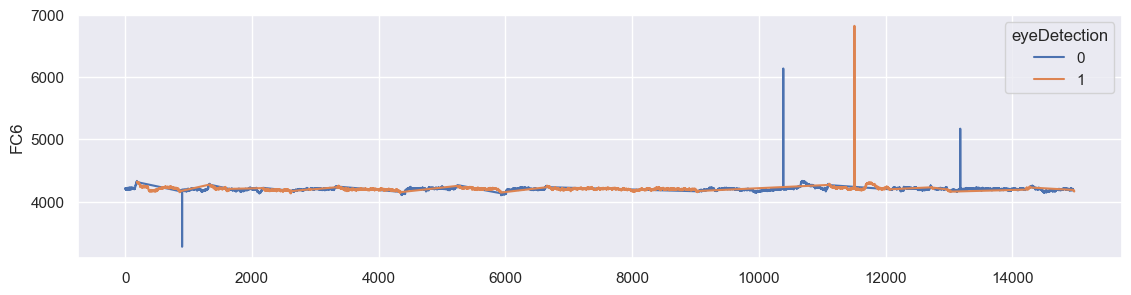

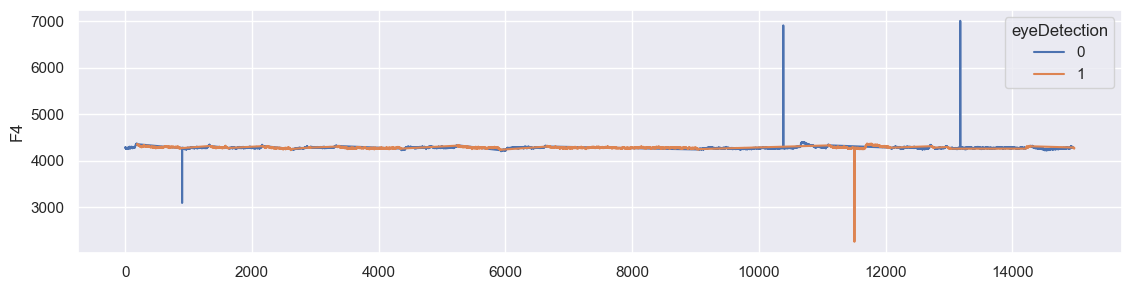

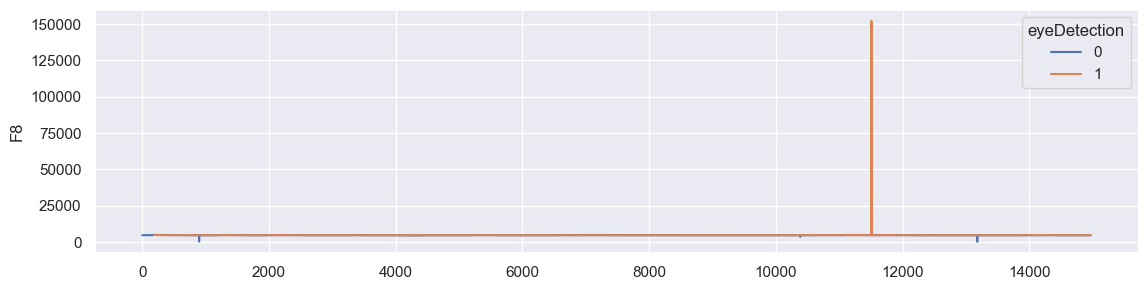

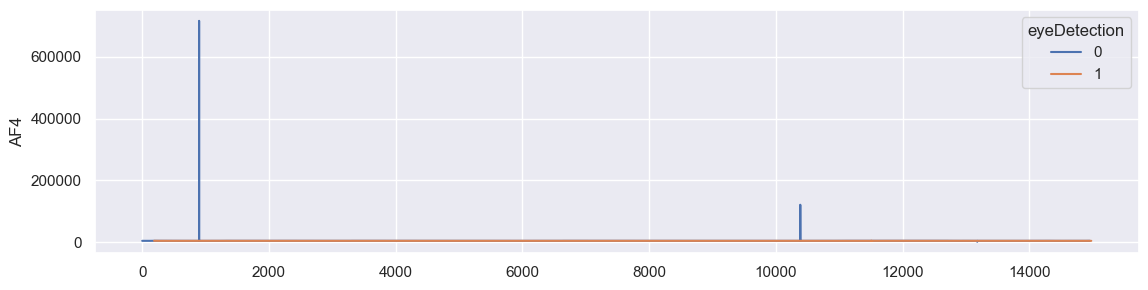

In [32]:
sns.set_theme(style='darkgrid')
for col in df.columns[0:-1]:
    plt.figure(figsize=(12, 3))
    sns.lineplot(x=df.index, y=col, data=df, hue="eyeDetection")
    plt.show()

#### Visualizing Eye Detection feature (target)



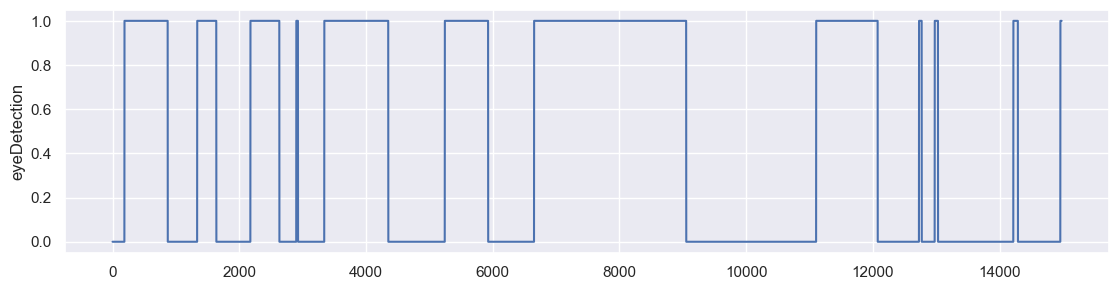

In [34]:
plt.figure(figsize=(12,3))
sns.lineplot(x=df.index, y=df.columns[-1], data=df)
plt.show()

### Detection and removing of outliers
Outliers are part of almost every dataset but these values could add serious biases to our models later.

Using the z-score to get rid of it il generally the best solution.
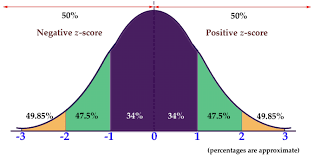

The z-score corresponds to the number of  σ
  (i.e. standard deviation) compared to the mean of the distribution

#### Visualizing outliers using a boxplot

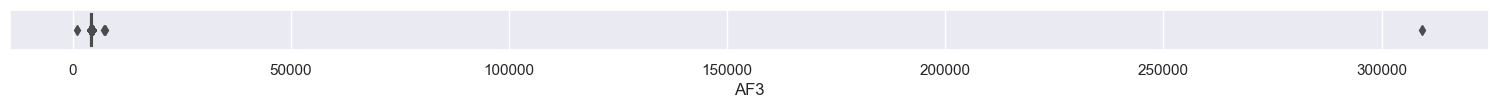

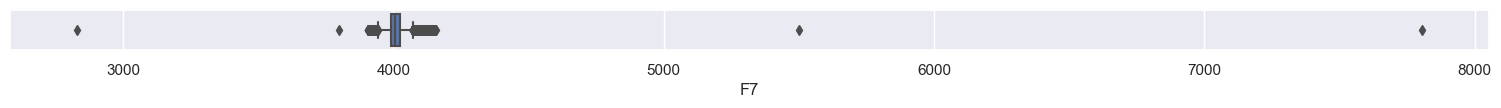

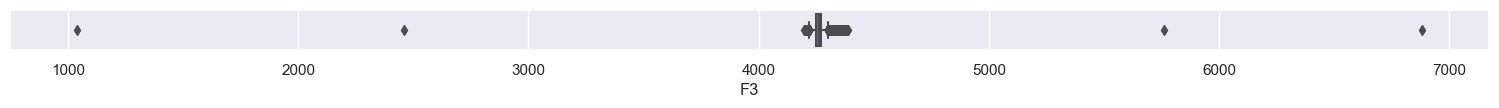

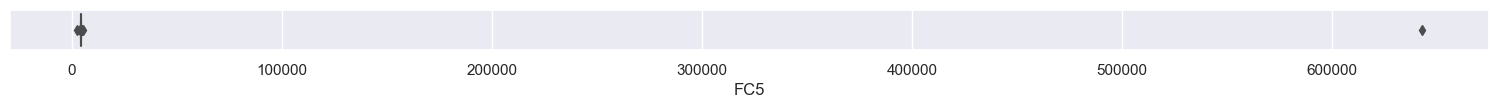

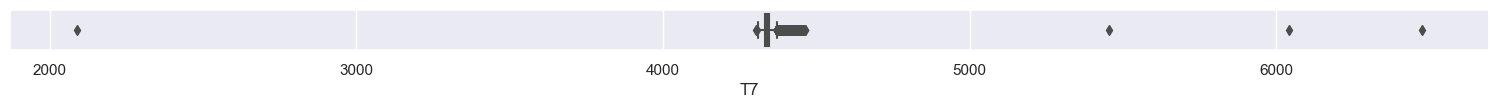

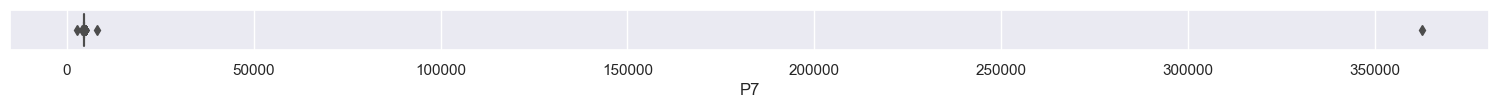

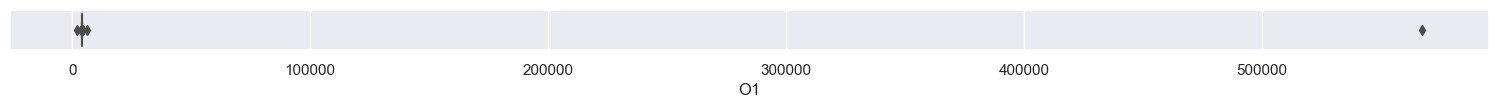

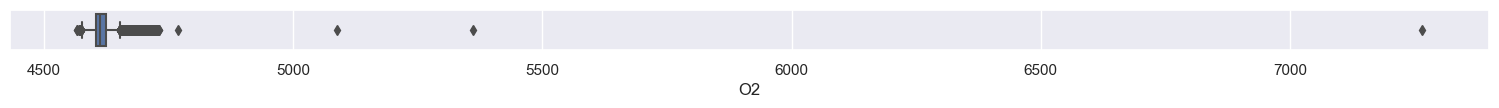

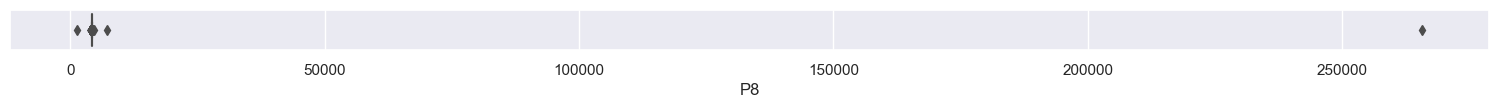

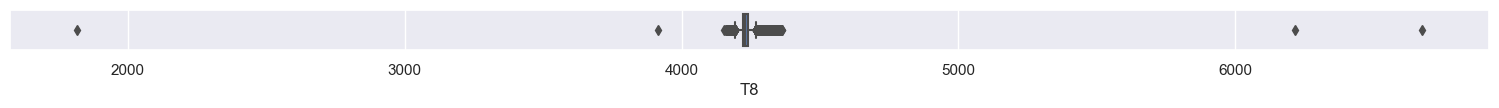

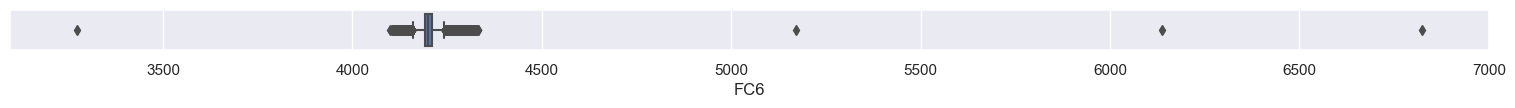

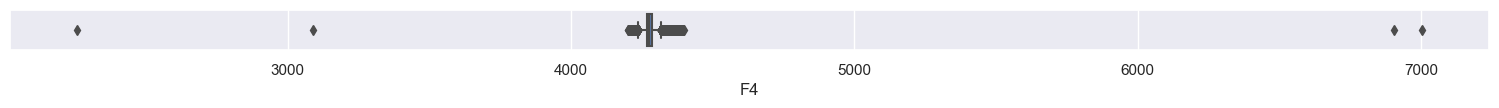

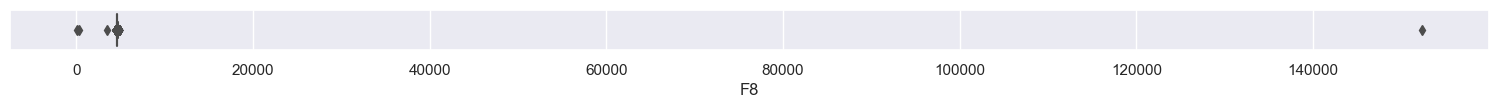

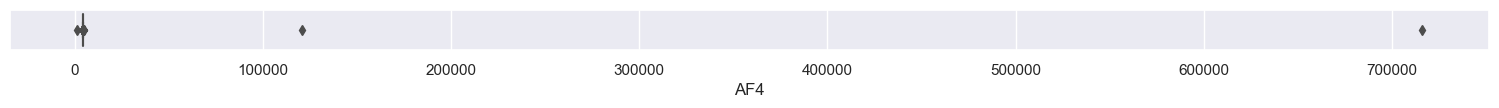

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [36]:
data_eeg = df.copy()

for column in data_eeg.columns[:-1] :
    plt.figure(figsize=(17,0.5))
    sns.boxplot(data = data_eeg, x=column)

#### Function to remove outliers


In [37]:
def Remove_outliers(dataframe, threshold=5):
    zscore = np.abs(stats.zscore(dataframe))
    filtered_entries= (zscore<threshold).all(axis=1) #True if not an outlier for all columns else false
    df_filtered = dataframe[filtered_entries].reset_index(drop=True)
    return df_filtered

df_filtered = Remove_outliers(df)
    

In [38]:
data_features = df.columns[:-1]


#### Function to compare plots before and after filtrations


In [39]:
def plot_difference(df_before, df_after, feature, filtration_type):
    plotcolor = next(color_cycle)
    
    #Before filtration process
    df_before.plot(figsize=(15,1), color=plotcolor, title=f'{feature} Before {filtration_type}')
    plt.show()
    
    #After filtration
    df_after.plot(figsize=(15,1), color=plotcolor, title=f'{feature} After {filtration_type}')
    plt.show()
    

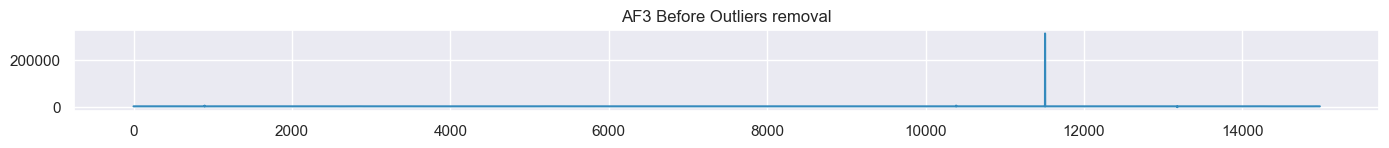

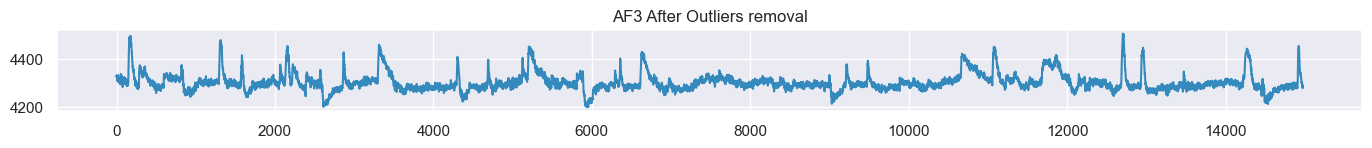

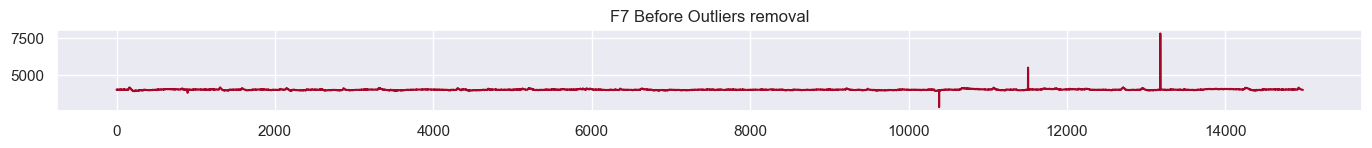

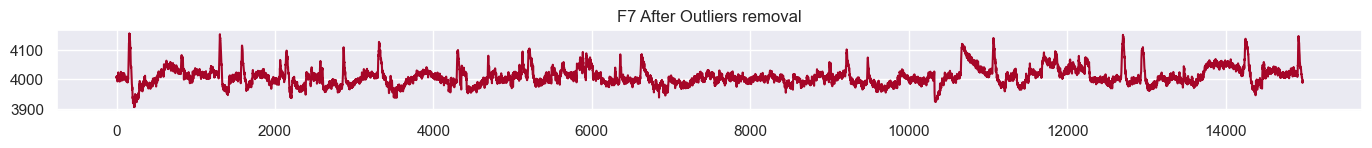

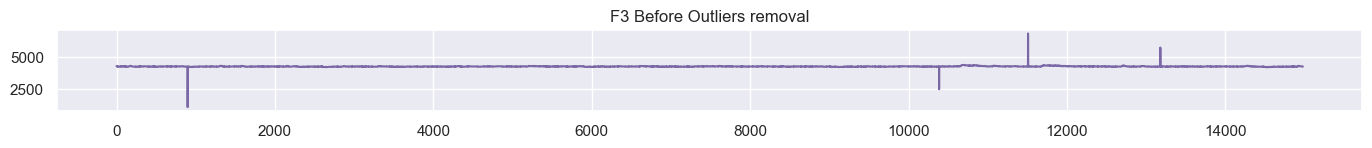

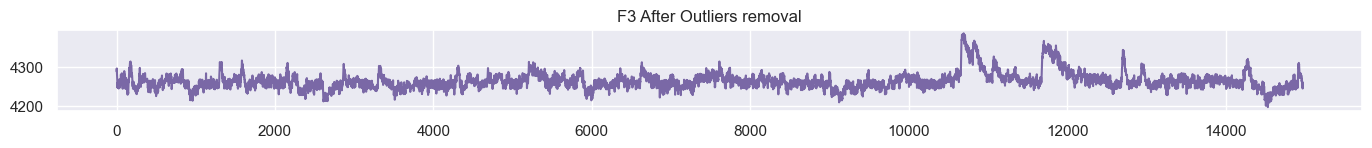

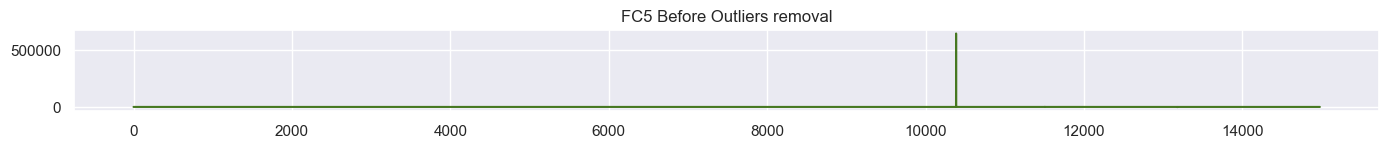

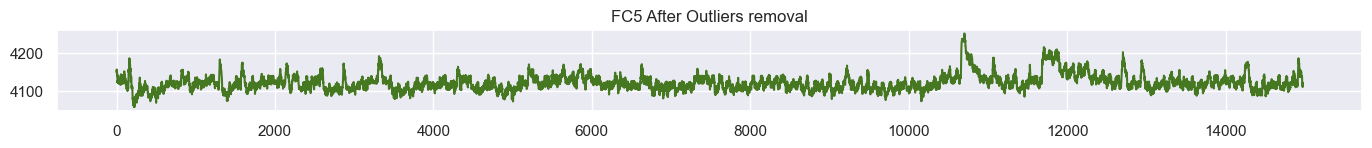

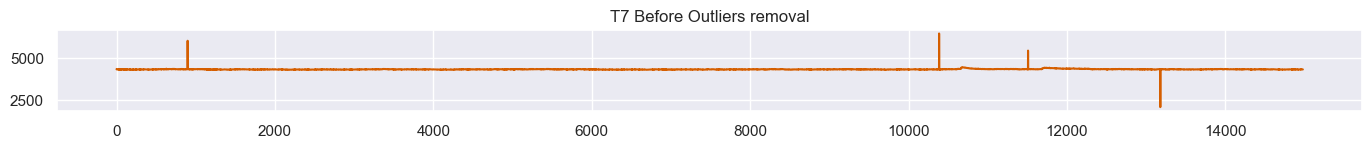

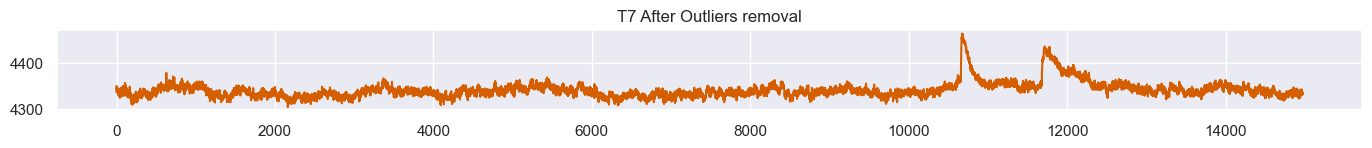

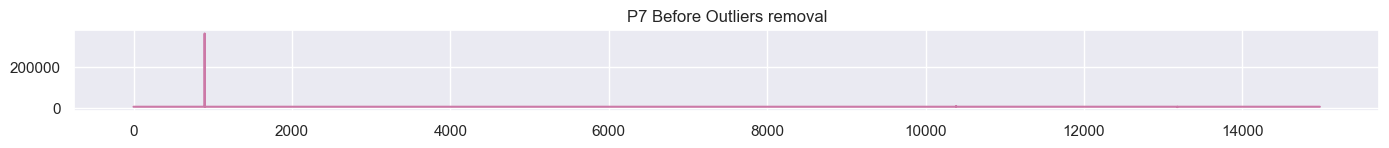

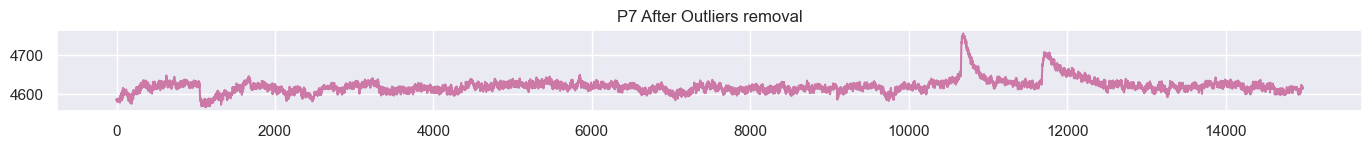

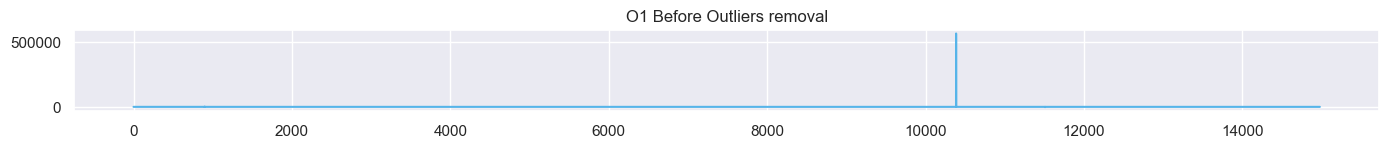

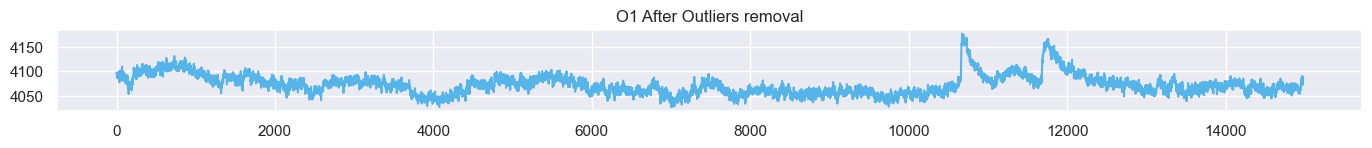

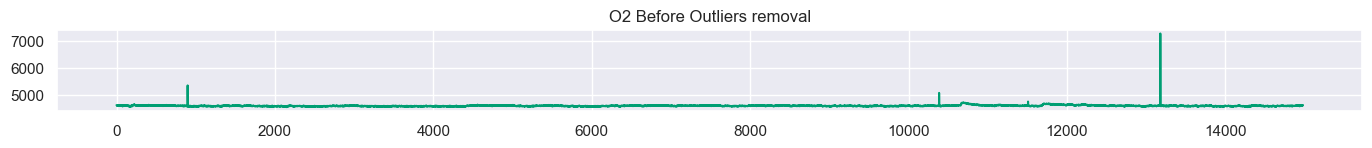

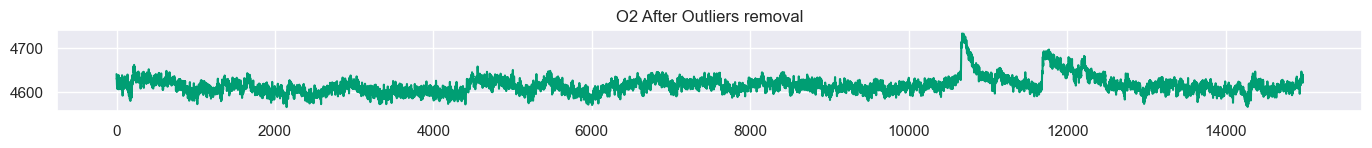

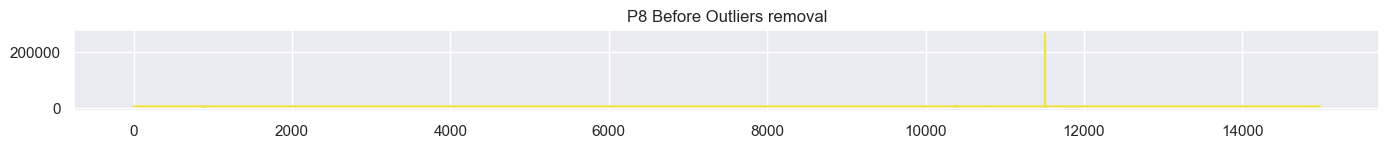

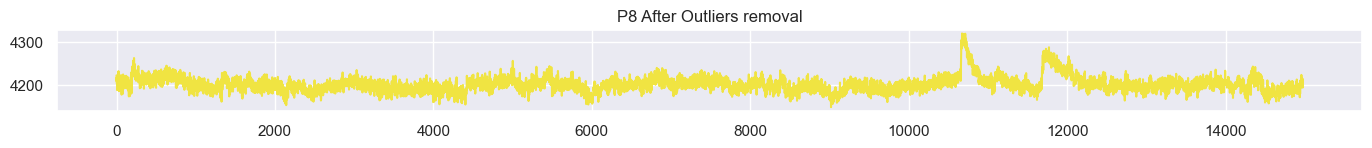

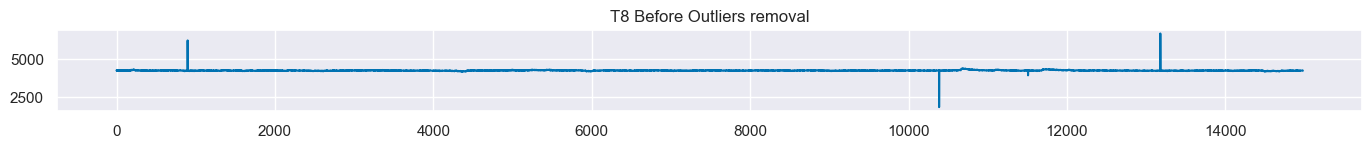

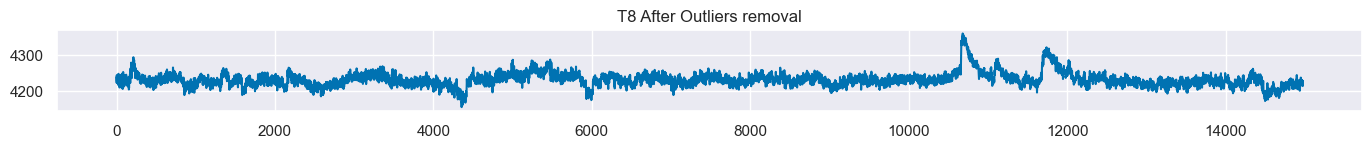

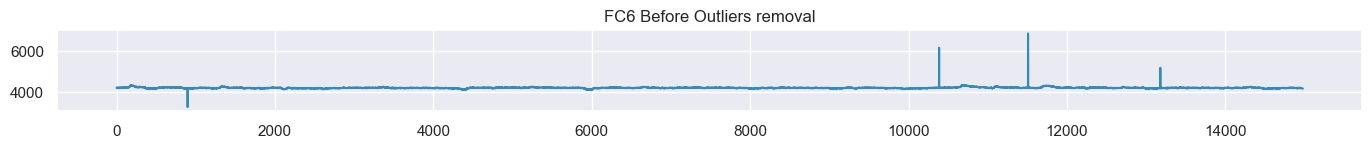

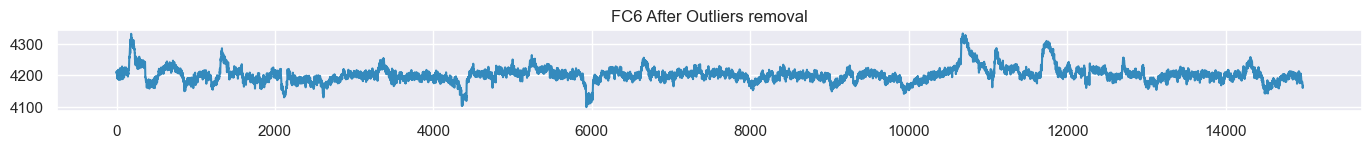

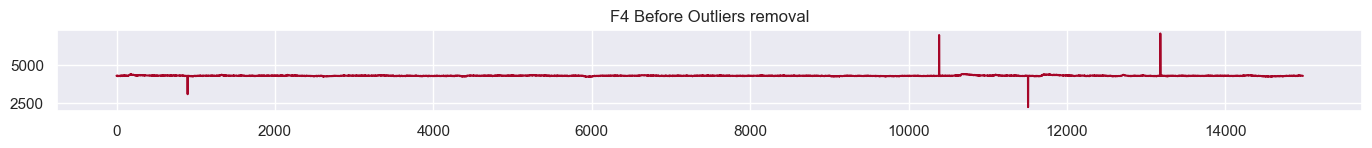

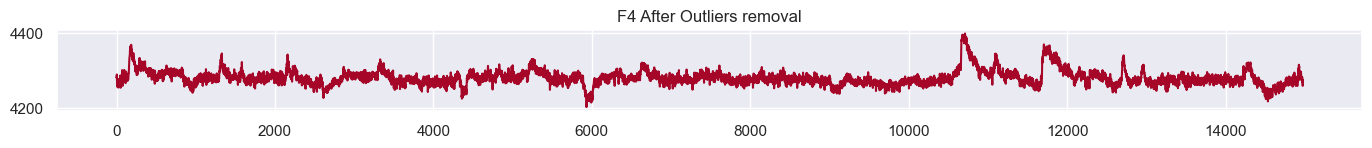

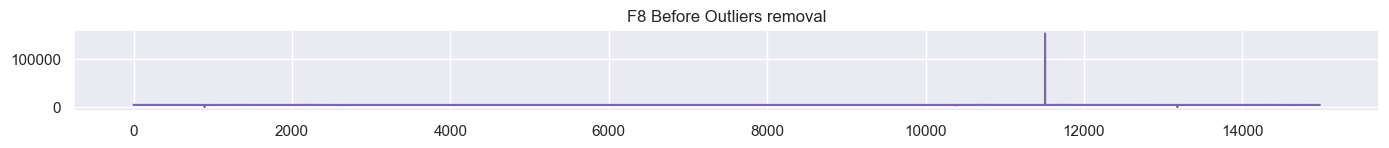

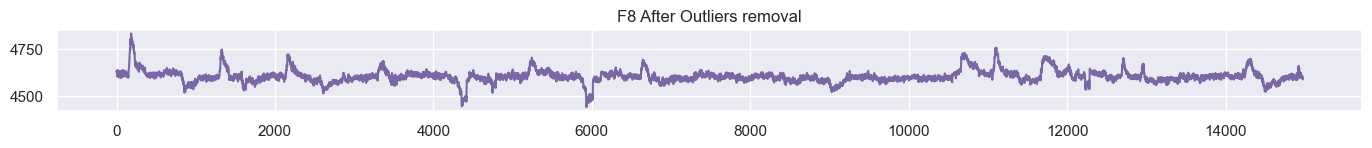

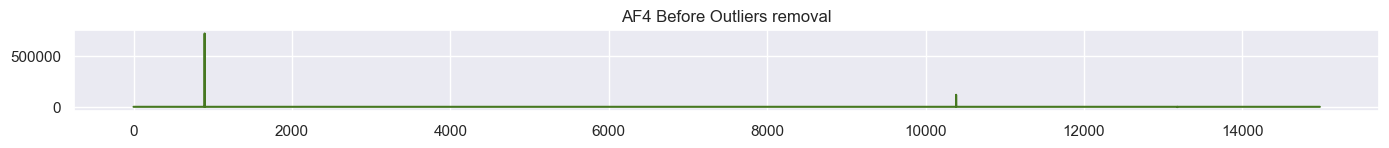

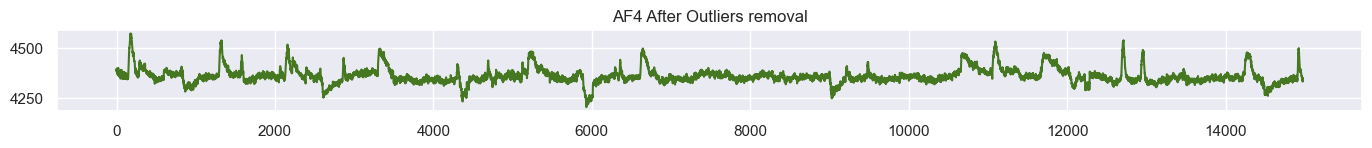

In [40]:
for feature in data_features:
    plot_difference(df[feature], df_filtered[feature] ,feature, 'Outliers removal' )

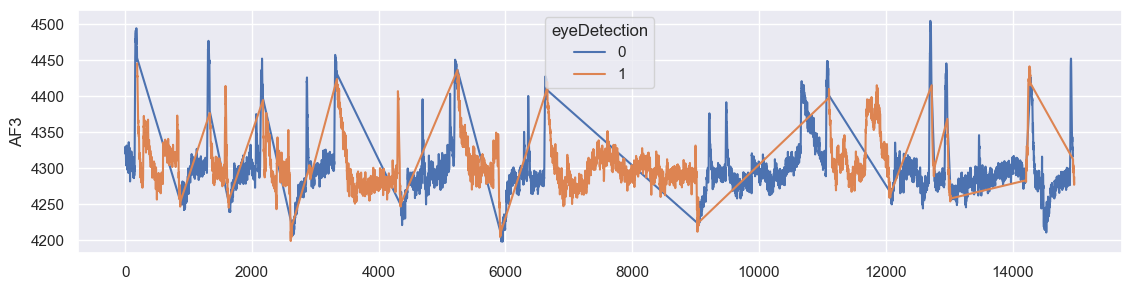

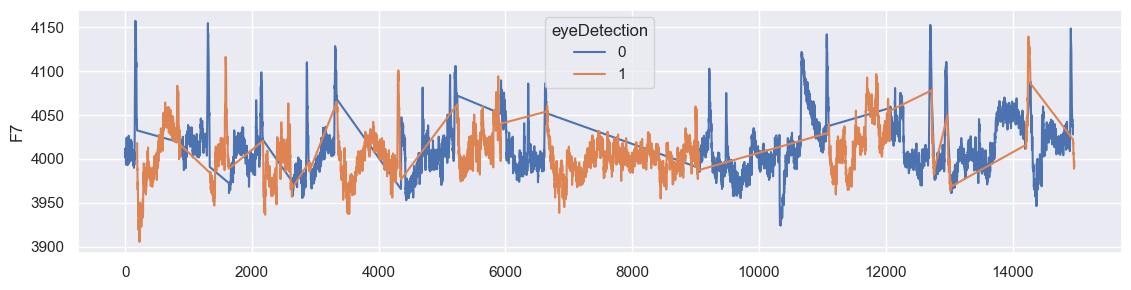

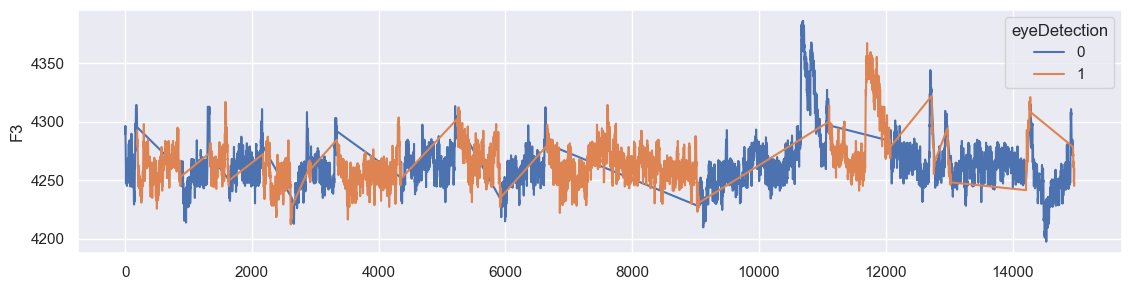

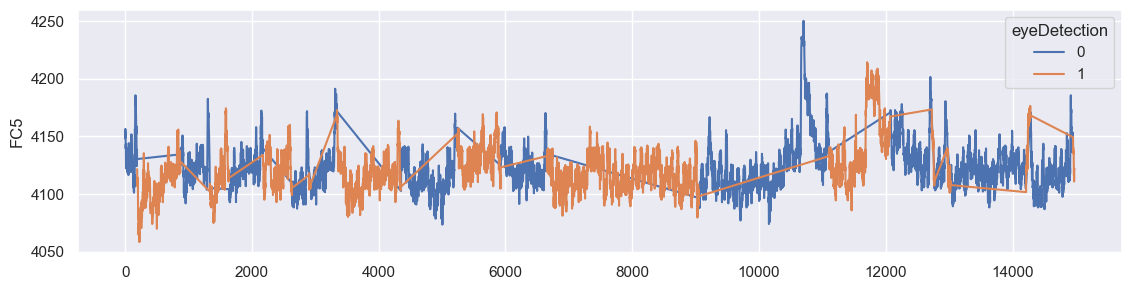

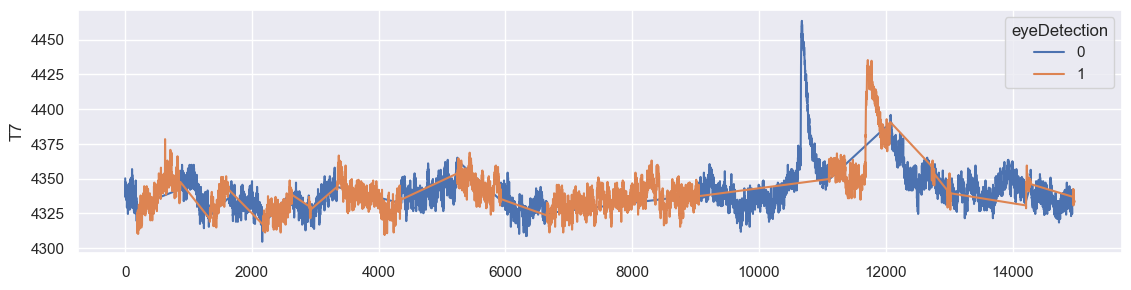

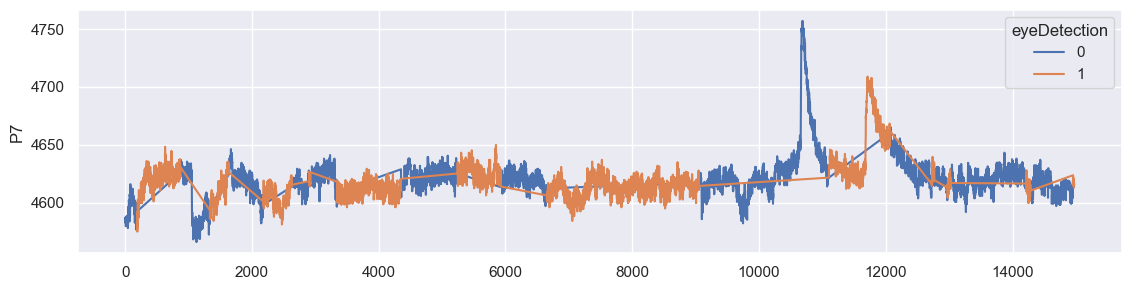

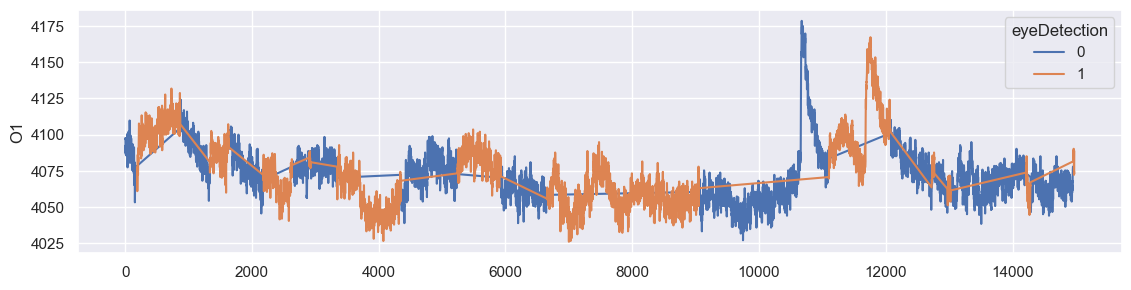

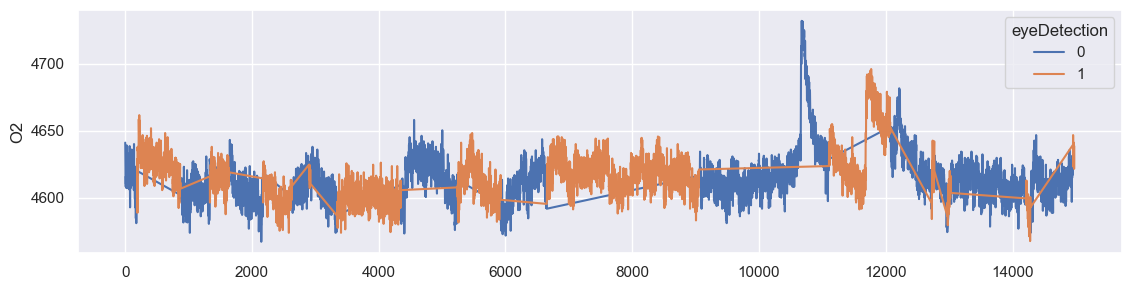

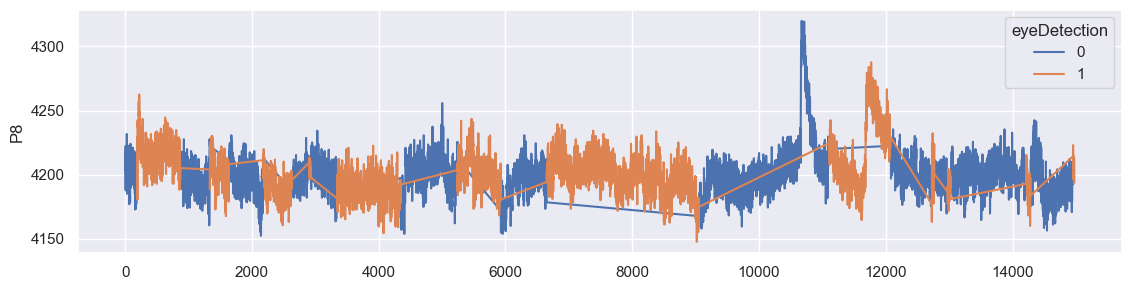

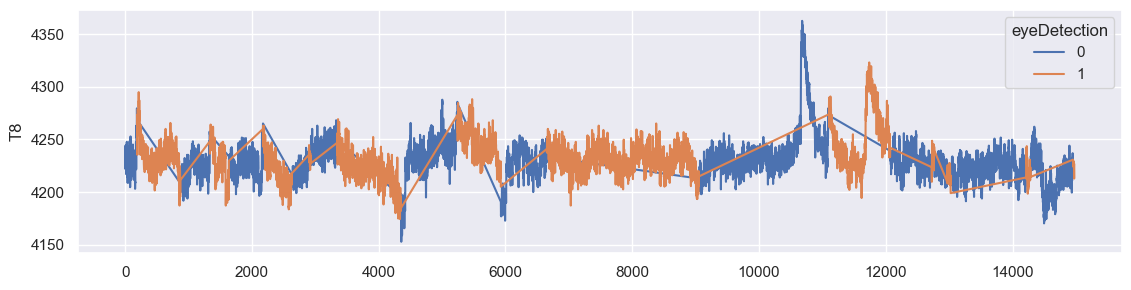

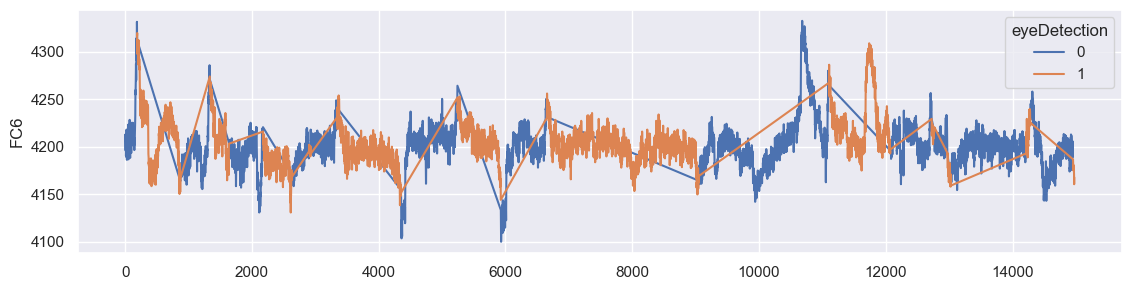

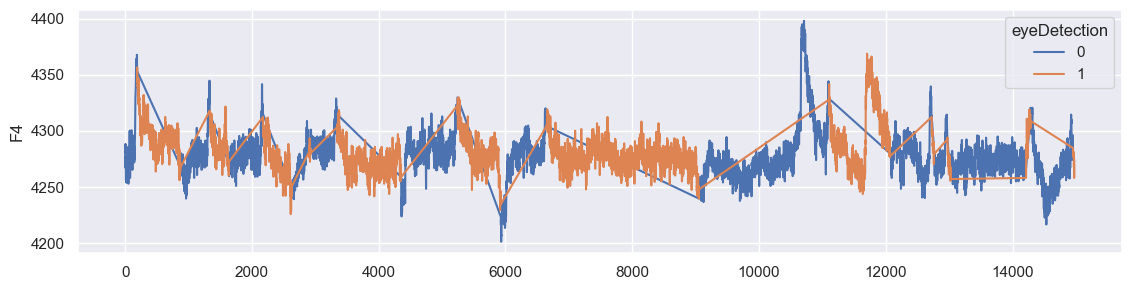

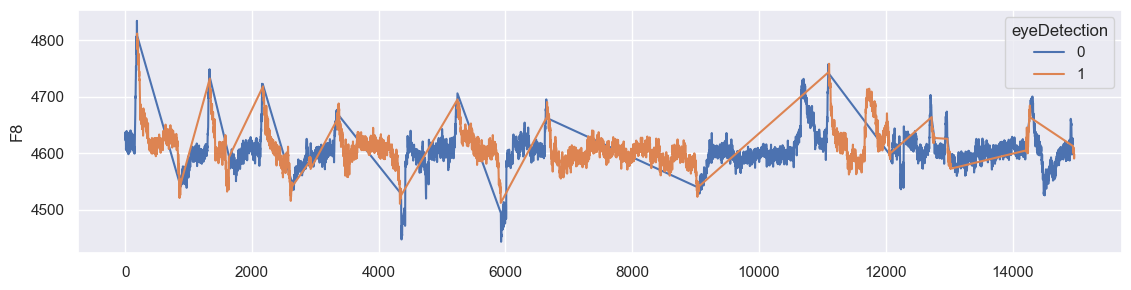

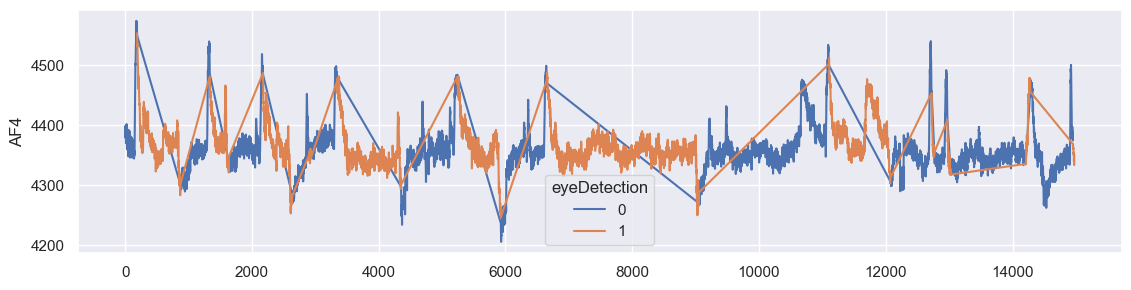

In [41]:
df_filtered_copy = df_filtered.copy()
for col in df_filtered_copy.columns[:-1]:
    plt.figure(figsize=(12, 3))
    sns.lineplot(x=df_filtered_copy.index, y=col, data=df_filtered_copy, hue="eyeDetection")
    plt.show()

#### Correlation between features

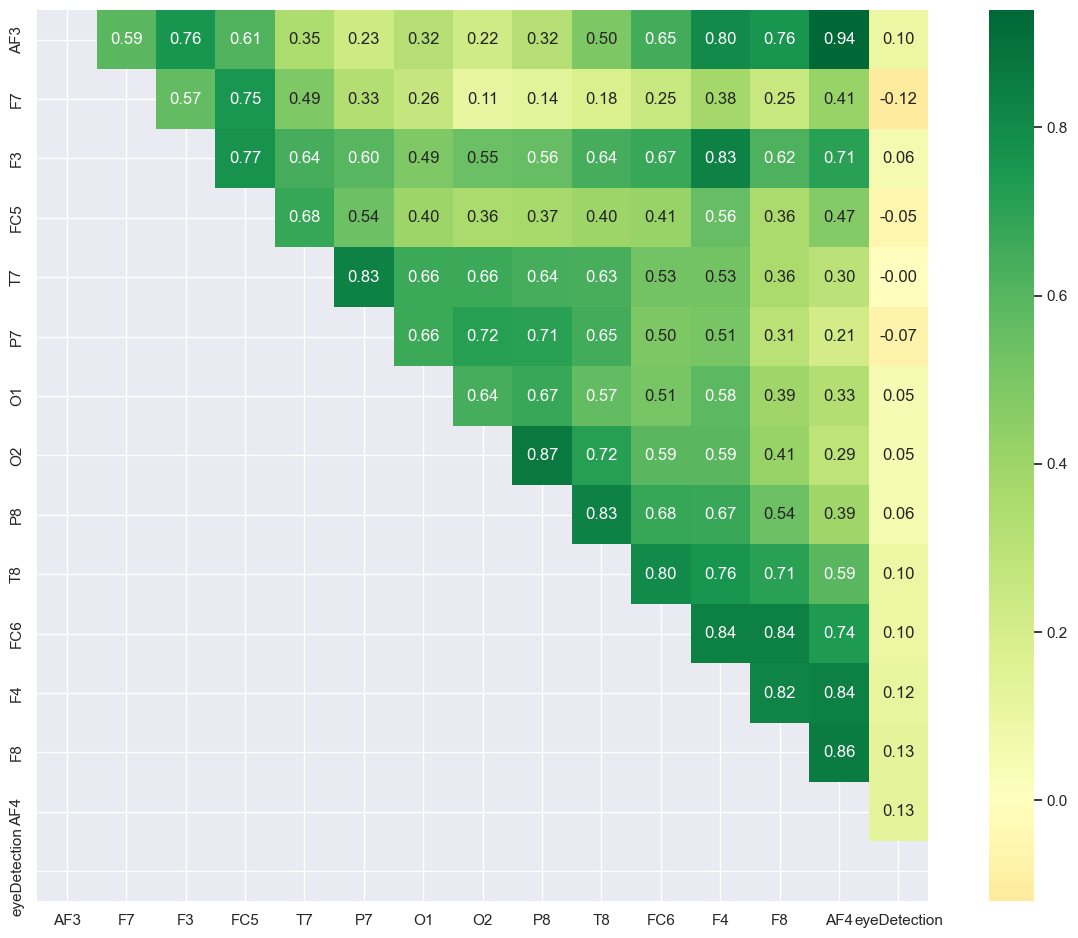

In [42]:
# Calculate pairwise-correlation
corr_matrix = df_filtered.corr().round(2)

# Create a mask
mask = np.tril(np.ones_like(corr_matrix, dtype=bool))

# Create a custom divergin palette
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center='light', as_cmap=True)

plt.figure(figsize=(14, 11))
sns.heatmap(corr_matrix, mask=mask, center=0, annot=True, 
            fmt='.2f', square=True, cmap='RdYlGn')
plt.show()

#### Bandpass filter 

In [47]:
from scipy.signal import butter, sosfiltfilt

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data


In [48]:
#Sampling rate
fs = 128  #fs = 14981 / 117

In [68]:
df_filtered_bandpass = df_filtered.copy()

# Specify EEG channels (feature columns) to be filtered
eeg_channels = df_filtered_bandpass.columns[:-1]

# Apply bandpass filter to EEG channels only
for column in eeg_channels:
    df_filtered_bandpass[column] = butter_bandpass_filter(df_filtered_bandpass[column], lowcut=0.5, highcut=40, fs=fs)


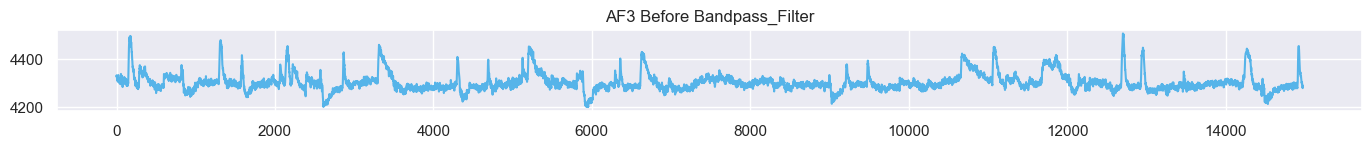

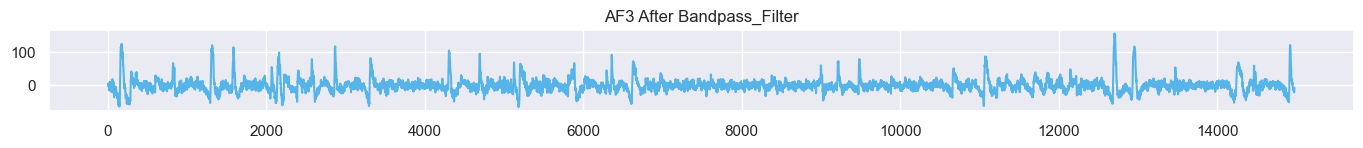

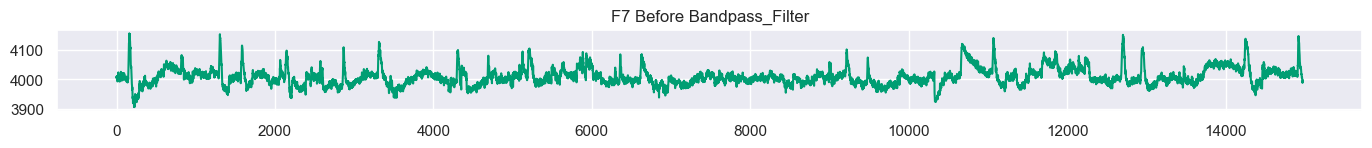

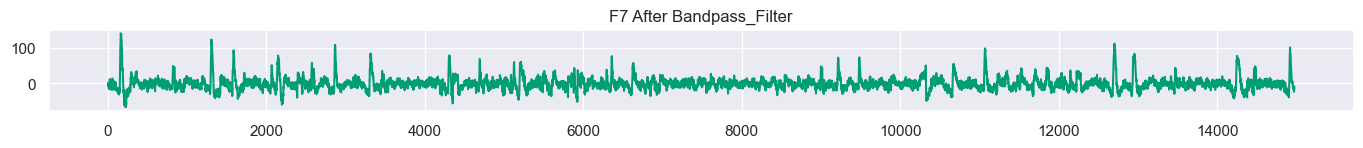

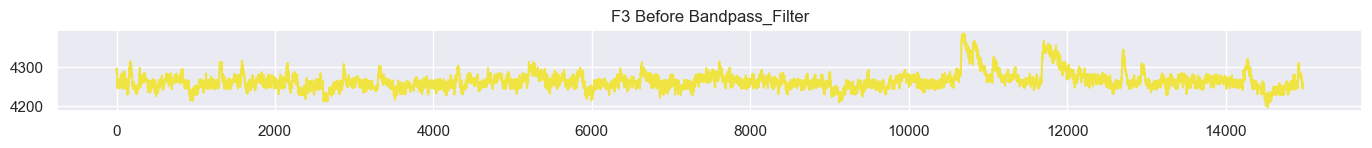

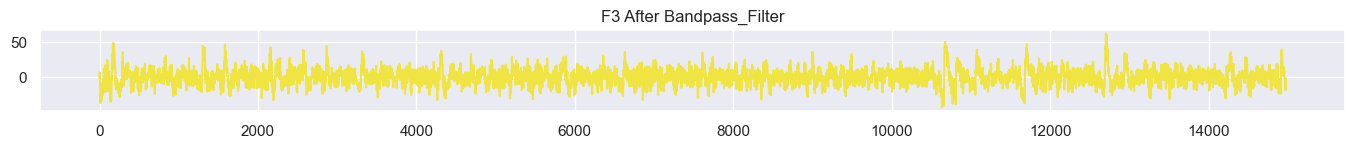

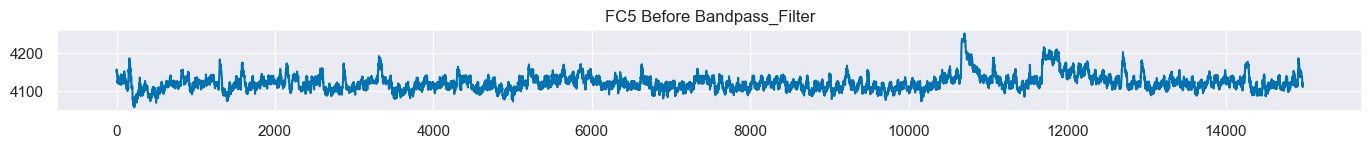

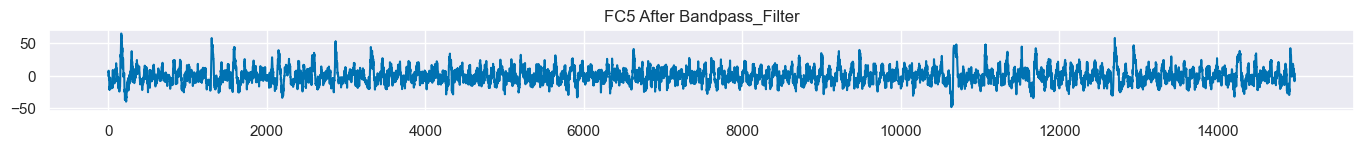

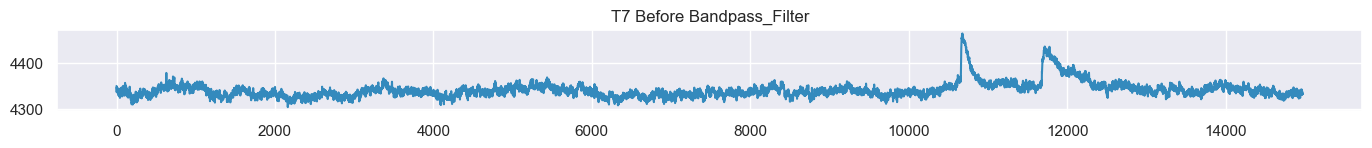

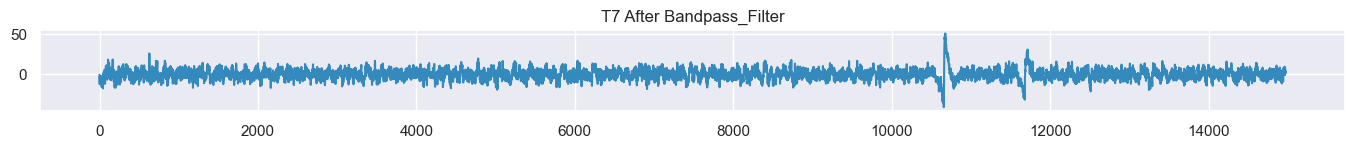

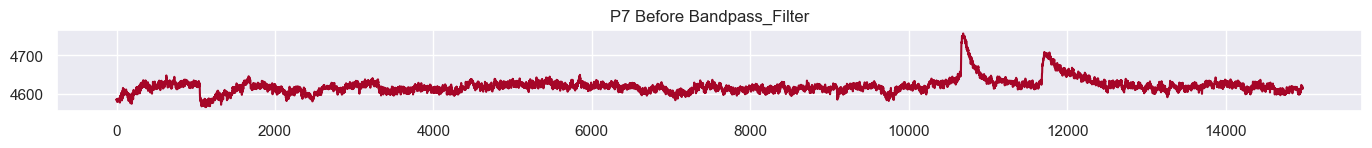

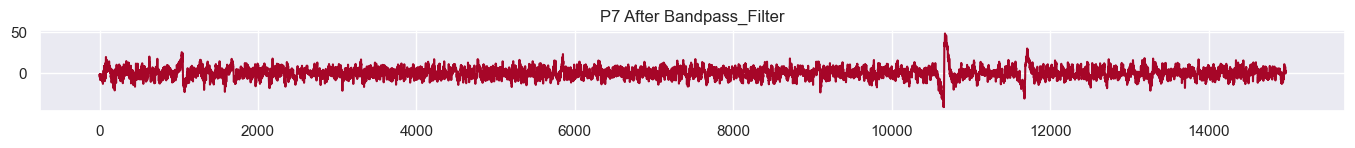

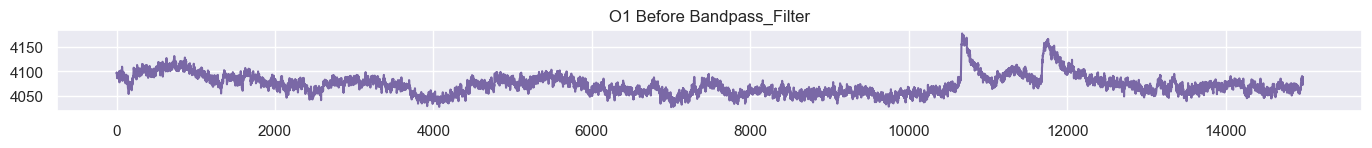

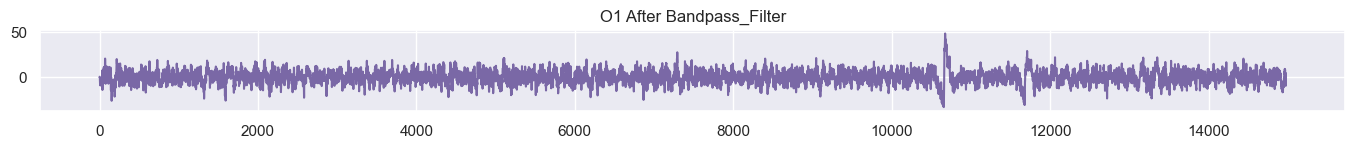

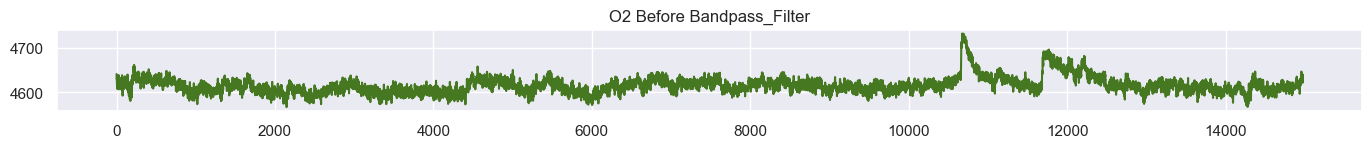

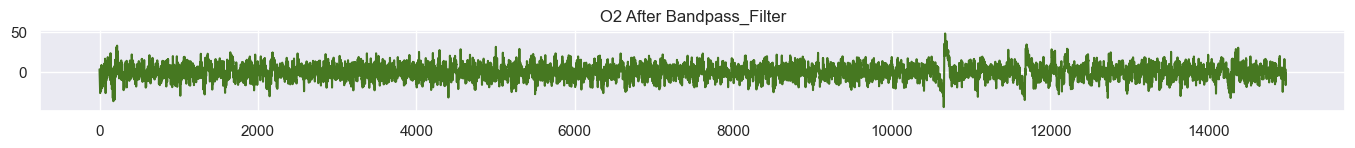

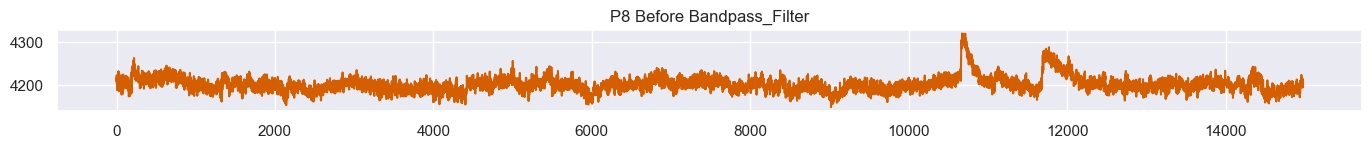

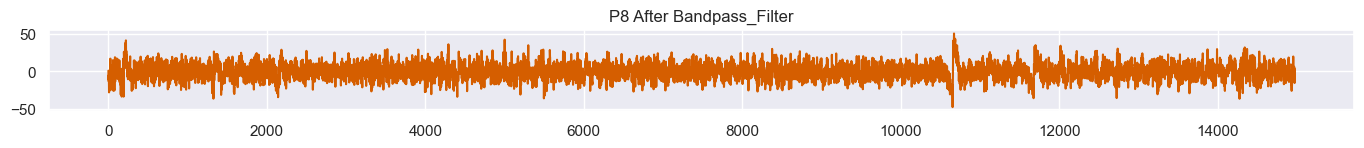

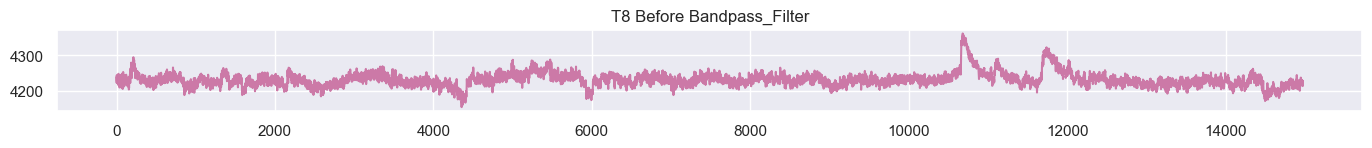

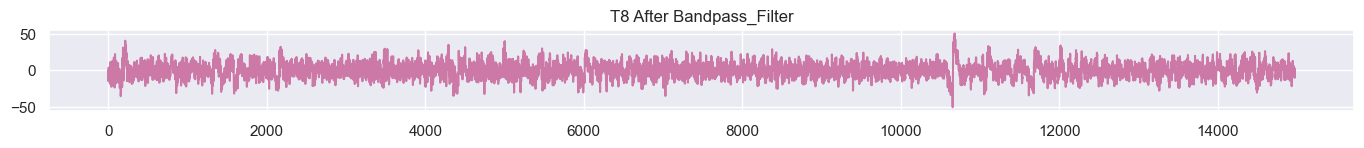

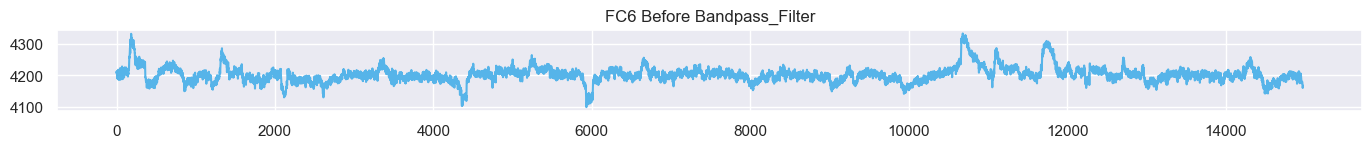

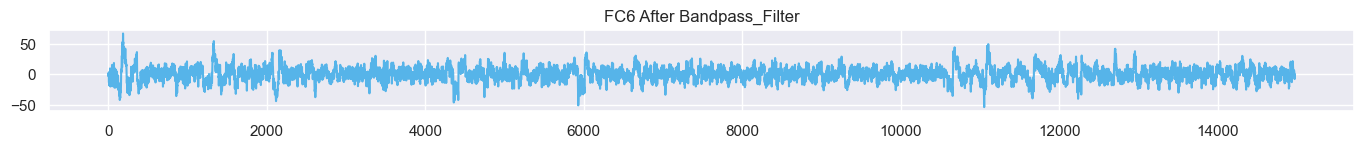

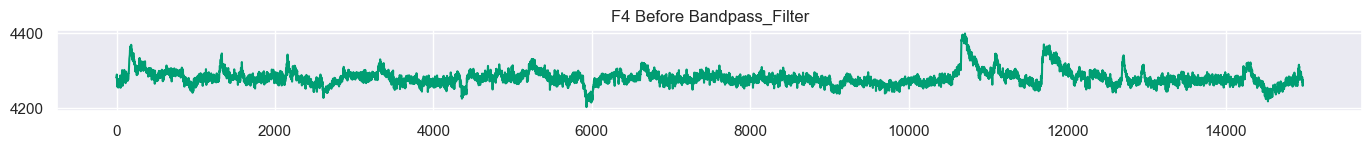

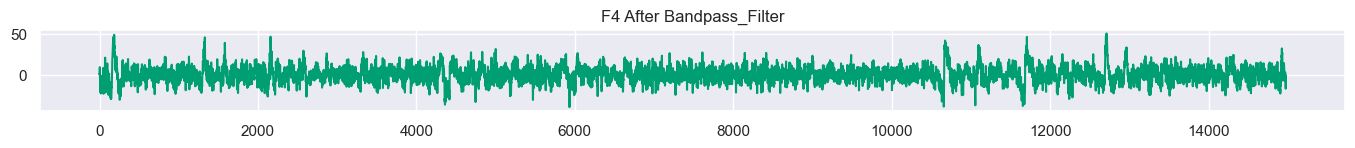

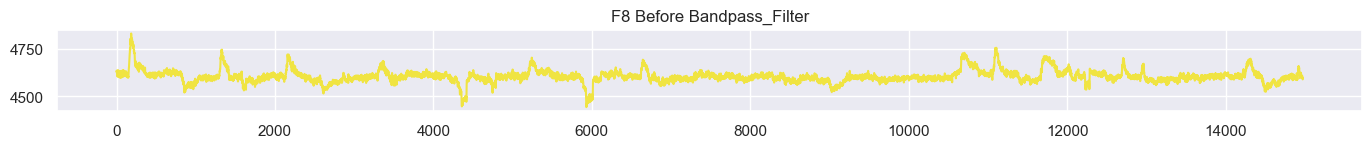

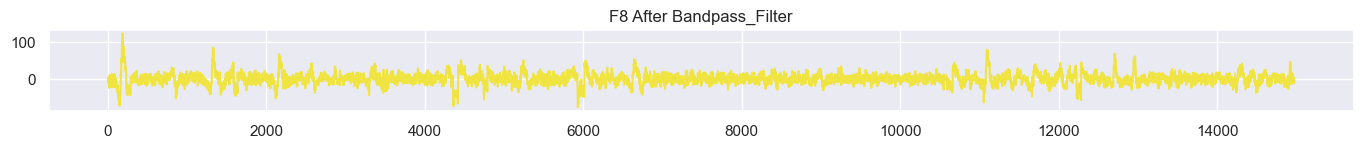

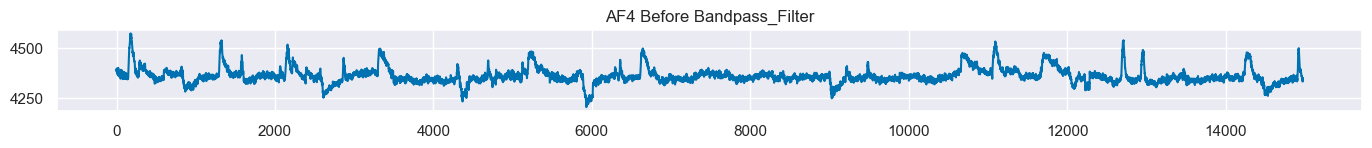

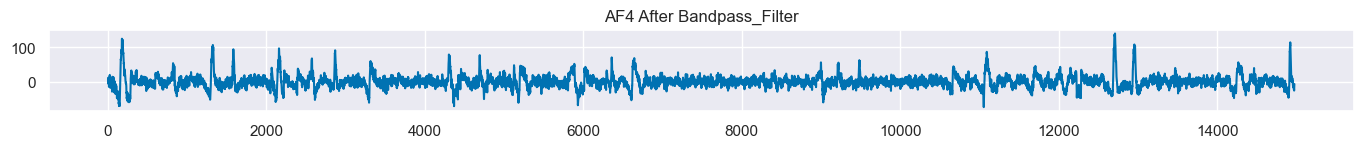

In [69]:
for feature in data_features:
   plot_difference(df_filtered[feature], df_filtered_bandpass[feature] ,feature, 'Bandpass_Filter')

In [73]:
df_filtered_bandpass


AF3         F7         F3       FC5         T7        P7  \
0       3.884235  -1.185667  -2.046185 -0.466036  -0.319831 -1.853658   
1       0.447370  -5.502644   2.610765  1.860163  -9.127968 -1.883237   
2       2.238374  -3.592067   5.703584  7.123862 -11.946298 -4.454798   
3       4.472559   1.431581   6.382513  7.810532  -7.048618 -5.058340   
4       1.727676   0.944183   2.508753  5.172815  -2.436714 -2.149410   
...          ...        ...        ...       ...        ...       ...   
14971 -20.307785 -20.954473 -17.869075 -5.552633   2.477022  0.784135   
14972 -21.656360 -18.428479 -18.769445 -8.403787   2.451283  1.709291   
14973 -19.484532 -17.813955 -16.654823 -4.911992   2.905244  2.082856   
14974 -12.782327 -15.399294 -11.282974  2.209288   3.723946  2.554241   
14975  -7.369129  -8.713557  -2.412647  3.402450   3.141642  2.743762   

             O1         O2         P8         T8       FC6         F4  \
0     -0.160083   3.130854   1.004933  -0.838620  0.333789   0.832210   
1      0.243652  -0.363781 -10.720154 -13.538475 -3.300331  -0.033412   
2      0.419786  -4.973808 -10.283882 -15.070381 -3.513942   2.962388   
3      0.383871  -6.694122  -5.200032  -3.385972 -0.005031   8.239190   
4     -0.518050 -10.428542  -9.671988   3.533556  2.647976   9.186878   
...         ...        ...        ...        ...       ...        ...   
14971 -9.009927 -12.638580  -5.802383  -4.361705 -0.357188  -8.116772   
14972 -9.759416 -16.498868 -13.146744  -7.819435 -6.588904 -16.040917   
14973 -9.710283 -15.830238 -15.501128 -10.459977 -8.059639 -17.344635   
14974 -4.087263 -10.483530  -8.951408  -6.177425 -3.720277  -9.524859   
14975  4.494283  -1.619329   2.989616   1.635989 -0.082321  -1.033740   

              F8        AF4  eyeDetection  
0       0.699504   5.811613             0  
1      -2.888107  -2.340835             0  
2      -4.433697   1.009834             0  
3      -2.355106   9.751199             0  
4      -1.246004  11.506136             0  
...          ...        ...           ...  
14971 -10.277450 -22.275450             1  
14972 -12.277587 -26.206425             1  
14973 -10.404257 -19.868209             1  
14974  -6.112486  -9.419911             1  
14975  -3.621642  -6.986693             1  

[14976 rows x 15 columns]

#### Common Average Reference (CAR):

* CAR is a spatial filtering technique that involves subtracting the average signal across all electrodes from each individual electrode. It is used to mitigate the impact of common noise sources across electrodes, making the data more representative of local neural activity.
* CAR is performed independently for each time point and each electrode.

In [74]:
#axis=0 refers to operations along the columns (calculate mean for each column).
#axis=1 refers to operations along the rows (perform subtraction column-wise in df_car).

# Calculate the mean for each electrode (column)
average_per_electrode = df_filtered_bandpass.mean(axis=0)

# Perform Common Average Reference (CAR)
df_filtered_bandpass_car = df_filtered_bandpass.copy()  # Make a copy to avoid modifying the original DataFrame
df_filtered_bandpass_car.iloc[:, :-1] = df_filtered_bandpass.iloc[:, :-1].sub(average_per_electrode[:-1], axis=1)


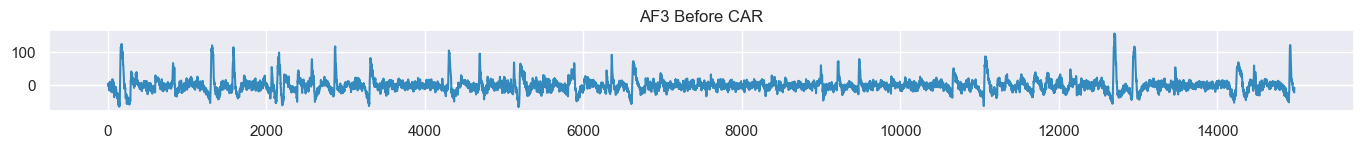

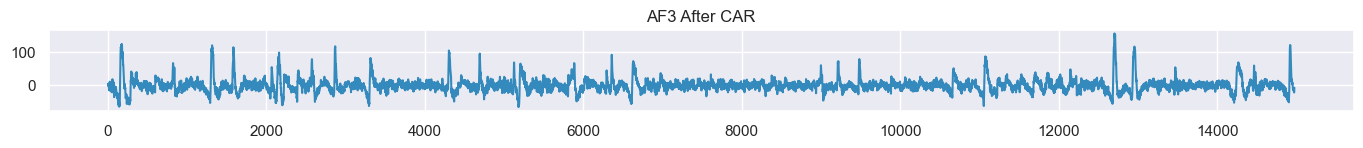

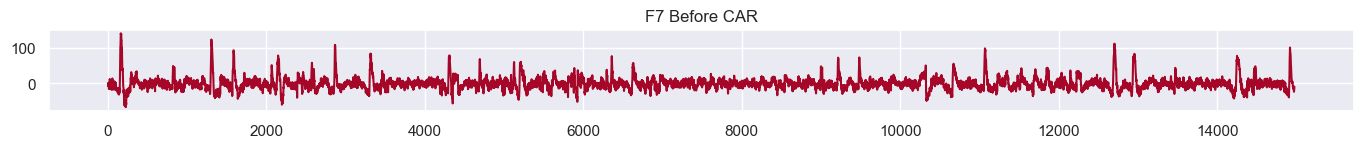

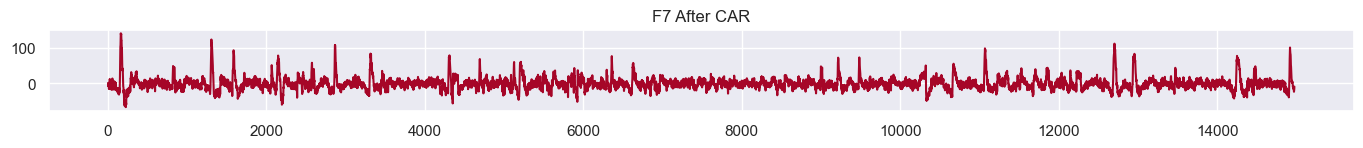

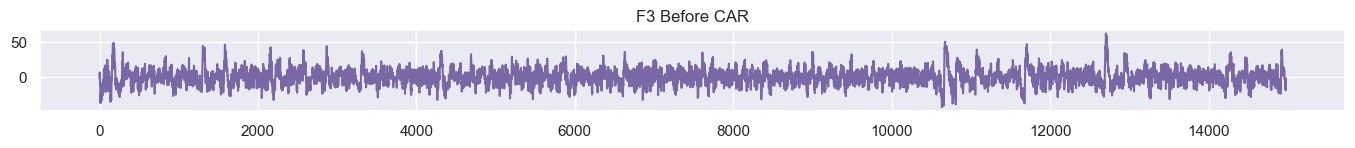

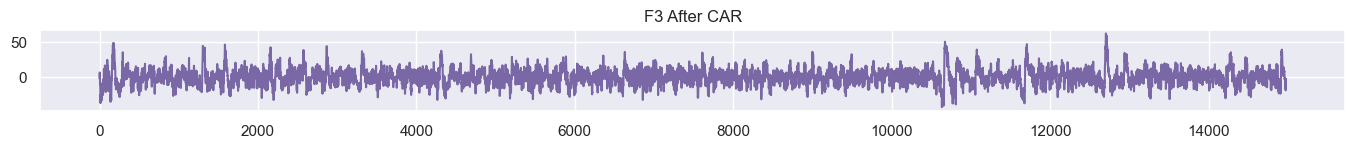

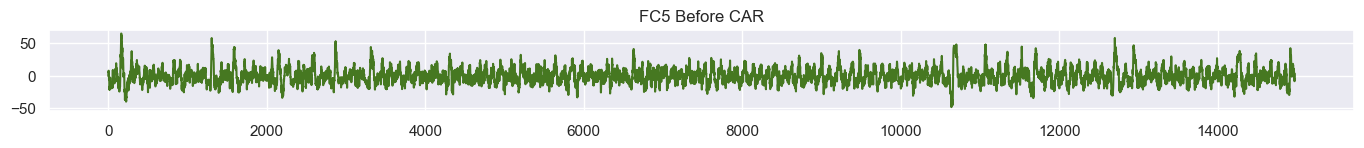

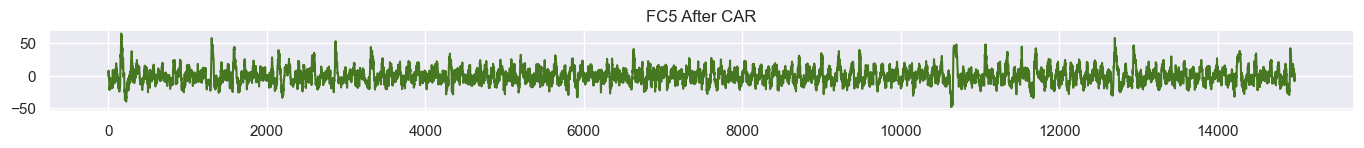

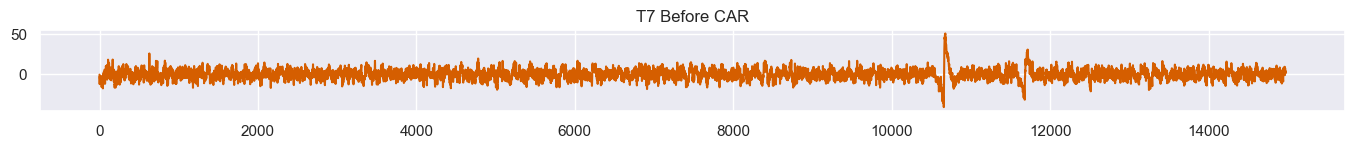

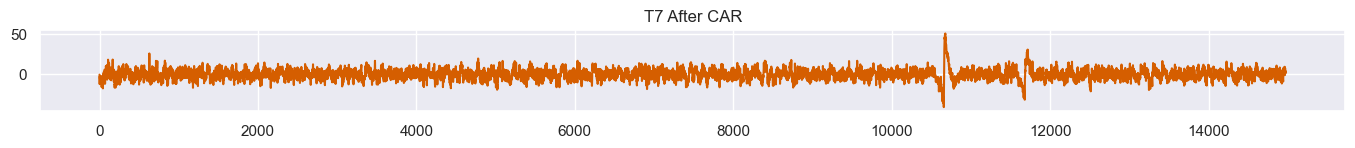

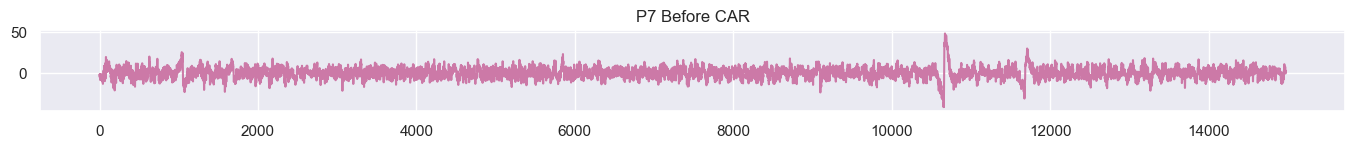

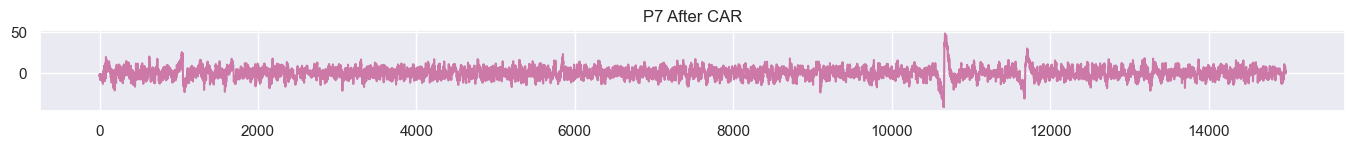

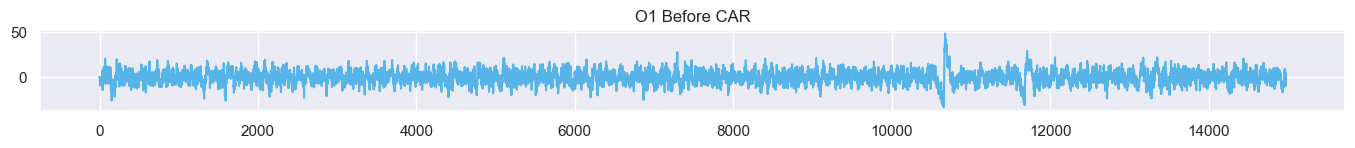

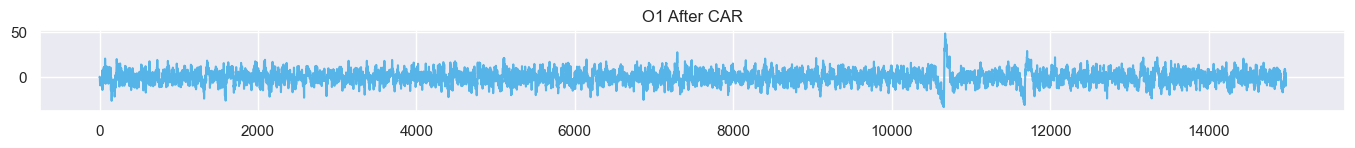

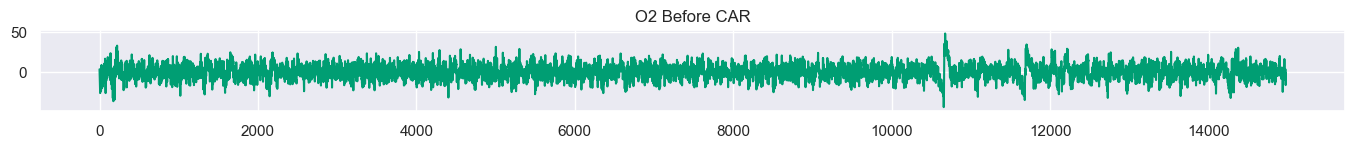

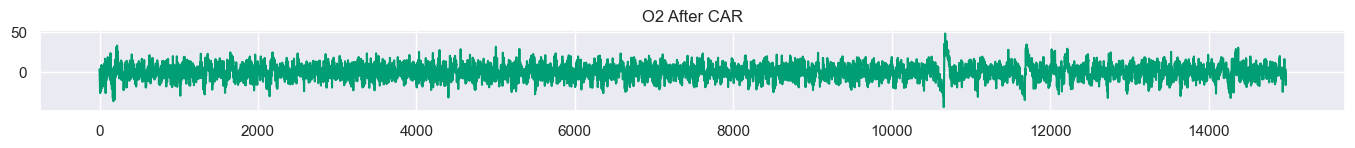

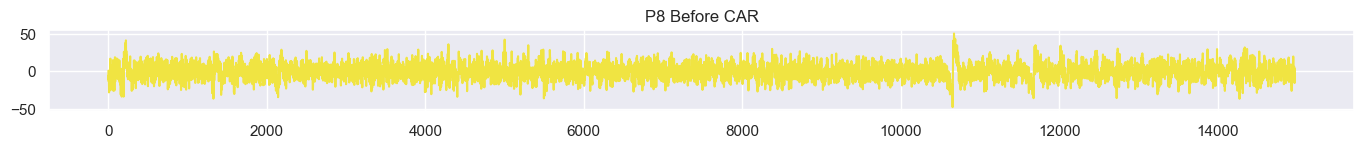

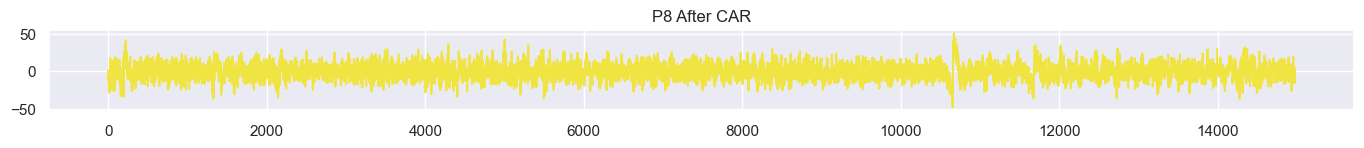

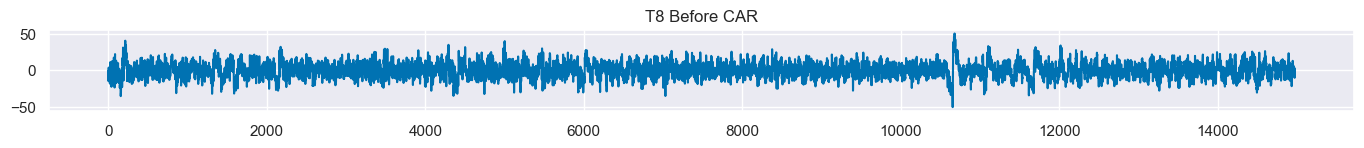

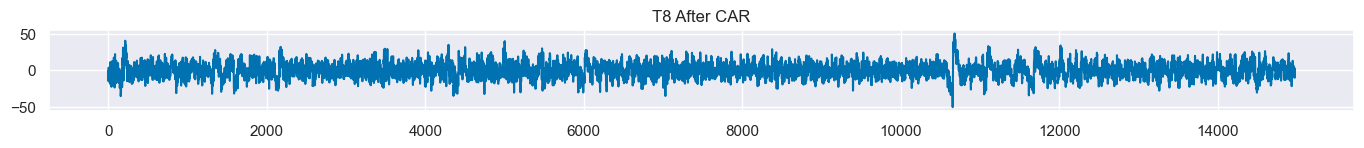

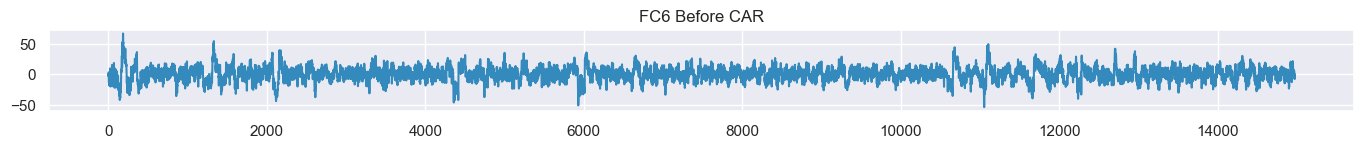

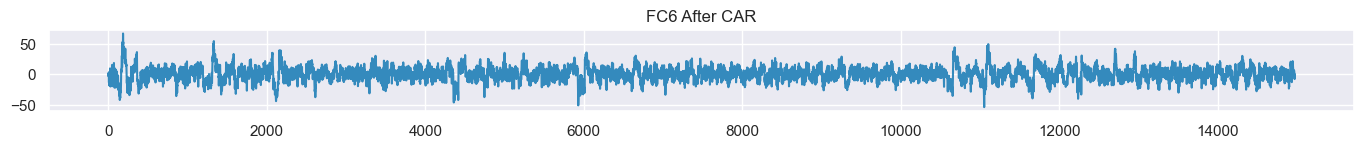

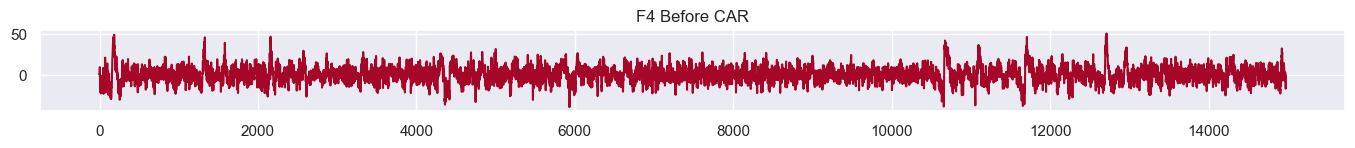

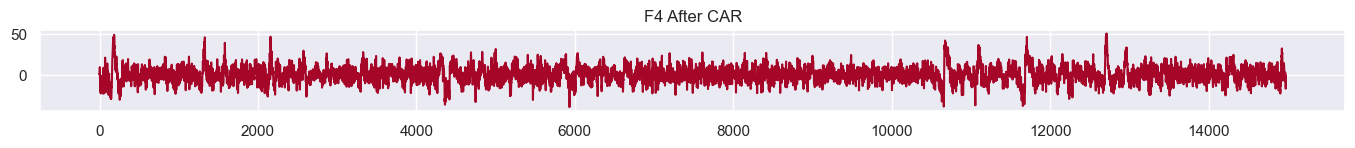

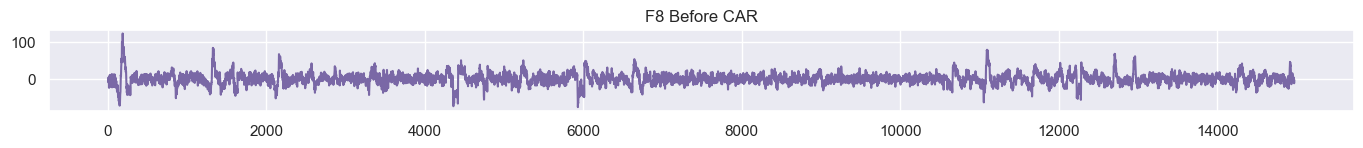

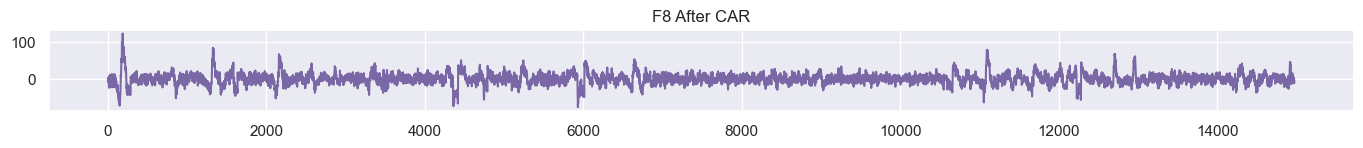

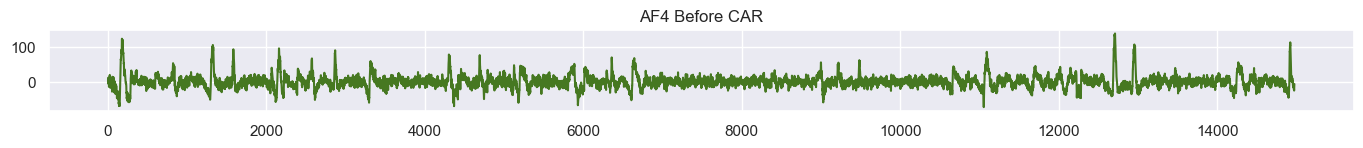

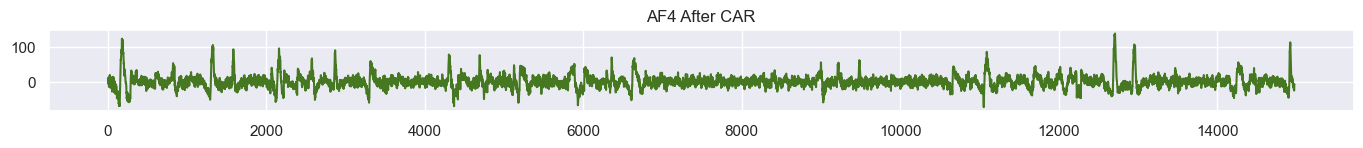

In [75]:
for feature in data_features:
   plot_difference(df_filtered_bandpass[feature], df_filtered_bandpass_car[feature] ,feature, 'CAR')

In [76]:
df_filtered_bandpass_car.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14976 entries, 0 to 14975
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14976 non-null  float64
 1   F7            14976 non-null  float64
 2   F3            14976 non-null  float64
 3   FC5           14976 non-null  float64
 4   T7            14976 non-null  float64
 5   P7            14976 non-null  float64
 6   O1            14976 non-null  float64
 7   O2            14976 non-null  float64
 8   P8            14976 non-null  float64
 9   T8            14976 non-null  float64
 10  FC6           14976 non-null  float64
 11  F4            14976 non-null  float64
 12  F8            14976 non-null  float64
 13  AF4           14976 non-null  float64
 14  eyeDetection  14976 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


In [77]:
df_filtered_bandpass_car

AF3         F7         F3       FC5         T7        P7  \
0       3.920791  -1.173402  -1.995778 -0.432385  -0.297377 -1.848718   
1       0.483925  -5.490379   2.661172  1.893814  -9.105513 -1.878298   
2       2.274929  -3.579801   5.753991  7.157512 -11.923844 -4.449858   
3       4.509115   1.443846   6.432920  7.844183  -7.026164 -5.053400   
4       1.764232   0.956449   2.559160  5.206465  -2.414260 -2.144470   
...          ...        ...        ...       ...        ...       ...   
14971 -20.271230 -20.942208 -17.818668 -5.518983   2.499476  0.789074   
14972 -21.619805 -18.416213 -18.719038 -8.370136   2.473737  1.714231   
14973 -19.447976 -17.801689 -16.604416 -4.878342   2.927699  2.087796   
14974 -12.745772 -15.387028 -11.232567  2.242939   3.746401  2.559181   
14975  -7.332574  -8.701291  -2.362240  3.436100   3.164097  2.748701   

             O1         O2         P8         T8       FC6         F4  \
0     -0.144082   3.167666   1.044465  -0.812294  0.357727   0.859739   
1      0.259653  -0.326969 -10.680623 -13.512149 -3.276394  -0.005884   
2      0.435787  -4.936996 -10.244350 -15.044056 -3.490004   2.989916   
3      0.399872  -6.657310  -5.160500  -3.359647  0.018906   8.266718   
4     -0.502049 -10.391730  -9.632456   3.559881  2.671913   9.214406   
...         ...        ...        ...        ...       ...        ...   
14971 -8.993926 -12.601767  -5.762851  -4.335380 -0.333251  -8.089244   
14972 -9.743415 -16.462056 -13.107212  -7.793110 -6.564967 -16.013389   
14973 -9.694281 -15.793426 -15.461596 -10.433652 -8.035702 -17.317106   
14974 -4.071262 -10.446717  -8.911877  -6.151099 -3.696340  -9.497330   
14975  4.510285  -1.582517   3.029148   1.662314 -0.058384  -1.006212   

              F8        AF4  eyeDetection  
0       0.741834   5.852529             0  
1      -2.845777  -2.299920             0  
2      -4.391367   1.050749             0  
3      -2.312776   9.792114             0  
4      -1.203674  11.547051             0  
...          ...        ...           ...  
14971 -10.235120 -22.234534             1  
14972 -12.235257 -26.165510             1  
14973 -10.361927 -19.827293             1  
14974  -6.070156  -9.378996             1  
14975  -3.579312  -6.945777             1  

[14976 rows x 15 columns]

In [64]:
df_filtered_bandpass

AF3         F7         F3       FC5         T7        P7  \
0       3.884235  -1.185667  -2.046185 -0.466036  -0.319831 -1.853658   
1       0.447370  -5.502644   2.610765  1.860163  -9.127968 -1.883237   
2       2.238374  -3.592067   5.703584  7.123862 -11.946298 -4.454798   
3       4.472559   1.431581   6.382513  7.810532  -7.048618 -5.058340   
4       1.727676   0.944183   2.508753  5.172815  -2.436714 -2.149410   
...          ...        ...        ...       ...        ...       ...   
14971 -20.307785 -20.954473 -17.869075 -5.552633   2.477022  0.784135   
14972 -21.656360 -18.428479 -18.769445 -8.403787   2.451283  1.709291   
14973 -19.484532 -17.813955 -16.654823 -4.911992   2.905244  2.082856   
14974 -12.782327 -15.399294 -11.282974  2.209288   3.723946  2.554241   
14975  -7.369129  -8.713557  -2.412647  3.402450   3.141642  2.743762   

             O1         O2         P8         T8       FC6         F4  \
0     -0.160083   3.130854   1.004933  -0.838620  0.333789   0.832210   
1      0.243652  -0.363781 -10.720154 -13.538475 -3.300331  -0.033412   
2      0.419786  -4.973808 -10.283882 -15.070381 -3.513942   2.962388   
3      0.383871  -6.694122  -5.200032  -3.385972 -0.005031   8.239190   
4     -0.518050 -10.428542  -9.671988   3.533556  2.647976   9.186878   
...         ...        ...        ...        ...       ...        ...   
14971 -9.009927 -12.638580  -5.802383  -4.361705 -0.357188  -8.116772   
14972 -9.759416 -16.498868 -13.146744  -7.819435 -6.588904 -16.040917   
14973 -9.710283 -15.830238 -15.501128 -10.459977 -8.059639 -17.344635   
14974 -4.087263 -10.483530  -8.951408  -6.177425 -3.720277  -9.524859   
14975  4.494283  -1.619329   2.989616   1.635989 -0.082321  -1.033740   

              F8        AF4  eyeDetection  
0       0.699504   5.811613      0.019104  
1      -2.888107  -2.340835      0.019487  
2      -4.433697   1.009834      0.019871  
3      -2.355106   9.751199      0.020257  
4      -1.246004  11.506136      0.020644  
...          ...        ...           ...  
14971 -10.277450 -22.275450      0.274181  
14972 -12.277587 -26.206425      0.260150  
14973 -10.404257 -19.868209      0.246028  
14974  -6.112486  -9.419911      0.231815  
14975  -3.621642  -6.986693      0.217512  

[14976 rows x 15 columns]

In [65]:
df_filtered

AF3       F7       F3      FC5       T7       P7       O1       O2  \
0      4329.23  4009.23  4289.23  4148.21  4350.26  4586.15  4096.92  4641.03   
1      4324.62  4004.62  4293.85  4148.72  4342.05  4586.67  4097.44  4638.97   
2      4327.69  4006.67  4295.38  4156.41  4336.92  4583.59  4096.92  4630.26   
3      4328.72  4011.79  4296.41  4155.90  4343.59  4582.56  4097.44  4630.77   
4      4326.15  4011.79  4292.31  4151.28  4347.69  4586.67  4095.90  4627.69   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14971  4281.03  3990.26  4245.64  4116.92  4333.85  4614.36  4074.87  4625.64   
14972  4276.92  3991.79  4245.13  4110.77  4332.82  4615.38  4073.33  4621.54   
14973  4277.44  3990.77  4246.67  4113.85  4333.33  4615.38  4072.82  4623.59   
14974  4284.62  3991.79  4251.28  4122.05  4334.36  4616.41  4080.51  4628.72   
14975  4287.69  3997.44  4260.00  4121.03  4333.33  4616.41  4088.72  4638.46   

            P8       T8      FC6       F4       F8      AF4  eyeDetection  
0      4222.05  4238.46  4211.28  4280.51  4635.90  4393.85             0  
1      4210.77  4226.67  4207.69  4279.49  4632.82  4384.10             0  
2      4207.69  4222.05  4206.67  4282.05  4628.72  4389.23             0  
3      4217.44  4235.38  4210.77  4287.69  4632.31  4396.41             0  
4      4210.77  4244.10  4212.82  4288.21  4632.82  4398.46             0  
...        ...      ...      ...      ...      ...      ...           ...  
14971  4203.08  4221.54  4171.28  4269.23  4593.33  4340.51             1  
14972  4194.36  4217.44  4162.56  4259.49  4590.26  4333.33             1  
14973  4193.33  4212.82  4160.51  4257.95  4591.79  4339.49             1  
14974  4200.00  4220.00  4165.64  4267.18  4596.41  4350.77             1  
14975  4212.31  4226.67  4167.69  4274.36  4597.95  4350.77             1  

[14976 rows x 15 columns]

#### Independent Component Analysis (ICA):
* Apply Independent Component Analysis (ICA) to identify and remove artifacts from the EEG signals. ICA is effective for removing sources of noise such as eye blinks and muscle artifacts.

In [81]:
df_filtered_bandpass_car_ICA = df_filtered_bandpass_car.copy()
# Create an ICA object
ica = FastICA(n_components=14, random_state=97, max_iter=800)

# Fit ICA to your EEG data (excluding the 'eyeDetection' column)
ica.fit(df_filtered_bandpass_car_ICA.drop('eyeDetection', axis=1))

# Apply ICA to the data
cleaned_data = ica.transform(df_filtered_bandpass_car_ICA.drop('eyeDetection', axis=1));

In [82]:
cleaned_eeg_data_ICA = pd.DataFrame(cleaned_data, columns=df_filtered_bandpass_car_ICA.columns[:-1])  # Exclude 'eyeDetection' column
cleaned_eeg_data_ICA['eyeDetection'] = df_filtered_bandpass_car_ICA['eyeDetection']  # Add 'eyeDetection' column back
cleaned_eeg_data_ICA

AF3        F7        F3       FC5        T7        P7        O1  \
0      0.011434 -0.306021 -0.722425 -0.058132 -0.163569 -0.428636 -0.072146   
1     -1.656599  0.477326 -0.054558  0.648091 -0.533716  1.122595  1.131600   
2     -2.301765  0.149195 -0.374984  0.751200 -0.385310  0.851382  1.879025   
3     -1.331252  0.349651 -0.807091 -0.015447  0.142509 -0.855710  1.297285   
4     -0.391842  1.880654 -1.315272 -0.283888  0.381963 -1.951441  0.438053   
...         ...       ...       ...       ...       ...       ...       ...   
14971  1.550416  0.332558 -1.744163  1.686244  0.144848  1.025834 -0.359862   
14972  1.428446  1.387134 -0.594718  1.149093  0.135140  0.833319 -0.744666   
14973  1.083939  1.709762 -0.592356  0.936447 -0.156307 -0.175938 -0.218727   
14974  0.404898  1.274020 -1.432467  0.777075 -0.270596 -0.689811  0.375435   
14975 -0.358820  0.077218 -0.735691  0.308401  0.035629  0.093365  0.275943   

             O2        P8        T8       FC6        F4        F8       AF4  \
0     -0.691309 -0.115043  0.464140  0.111845  0.289500  0.514814  0.242696   
1     -1.467836 -0.255425 -0.254989  0.629363  0.264348 -0.726365  0.549246   
2     -0.192665 -0.694772 -0.140152  0.875397  0.364705 -0.541413 -0.070530   
3      0.971517 -1.569504  0.226553  0.468089  0.272618  0.173187 -1.289093   
4      1.150792 -2.328769  0.579742 -0.006364 -0.043266 -0.141107 -1.754386   
...         ...       ...       ...       ...       ...       ...       ...   
14971  1.666664 -0.428335  1.989300  0.487347 -1.200847 -0.948781  0.604088   
14972  1.390774  0.510021  1.552895  0.542737 -1.078228 -1.269402  1.228043   
14973  0.861512  0.740996  1.520345  0.399229 -0.869111 -1.124210  1.924199   
14974  1.025182  0.292368  1.792149 -0.121216 -0.687707 -0.362276  1.324195   
14975  1.315945  0.139195  1.109949 -0.563072 -0.605246  0.429405 -0.076041   

       eyeDetection  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
14971             1  
14972             1  
14973             1  
14974             1  
14975             1  

[14976 rows x 15 columns]

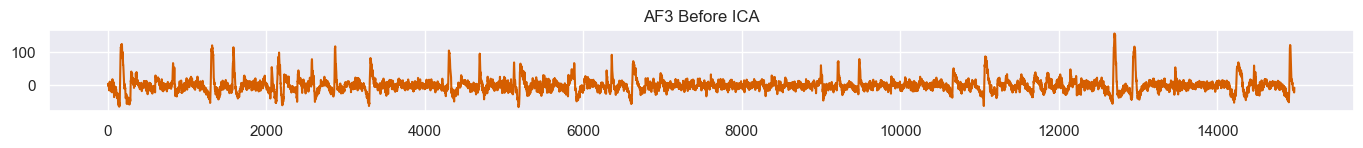

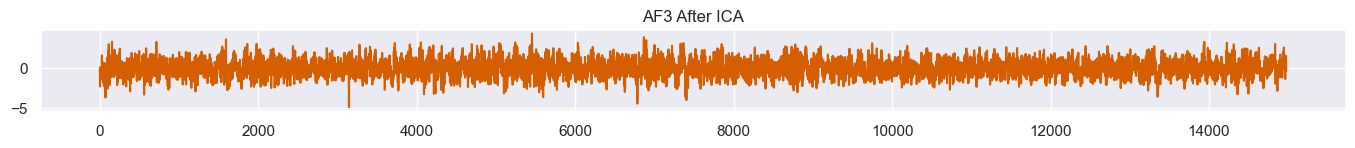

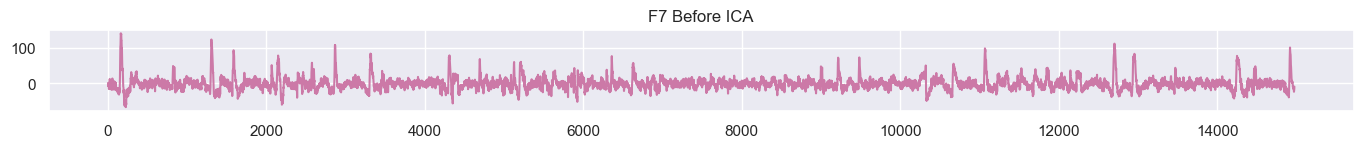

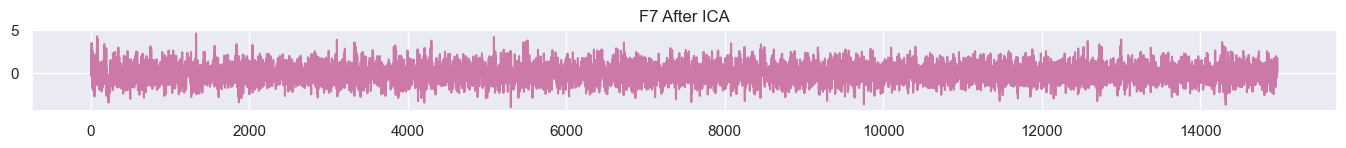

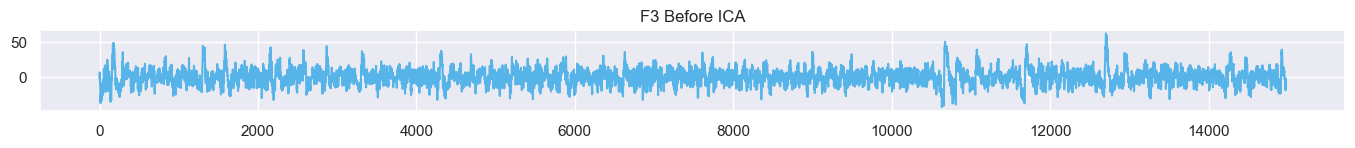

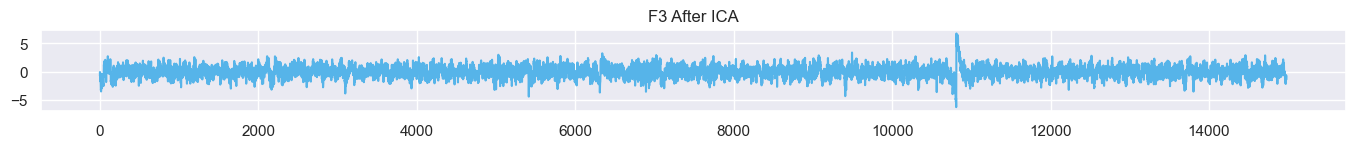

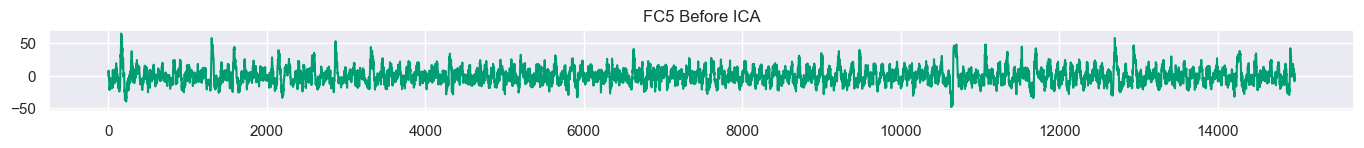

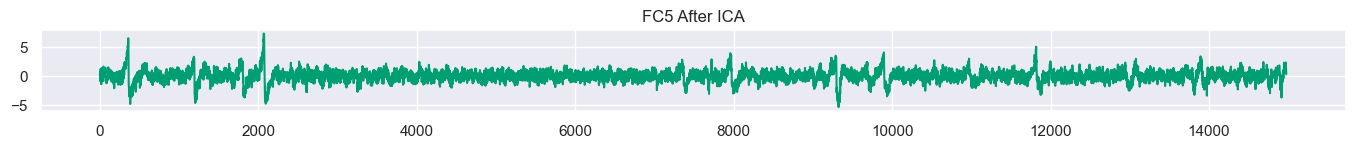

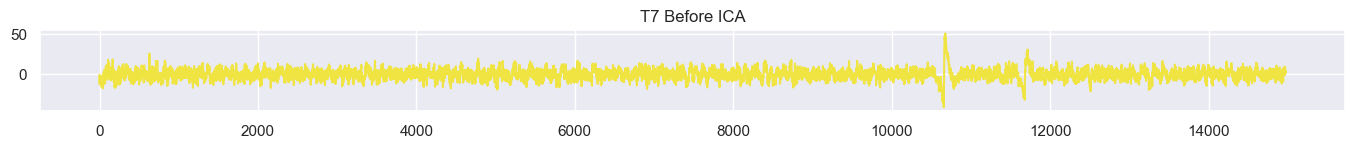

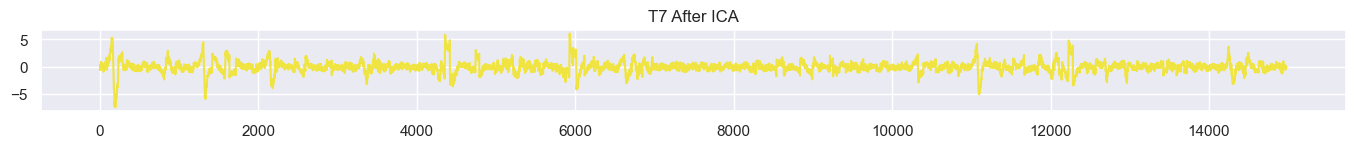

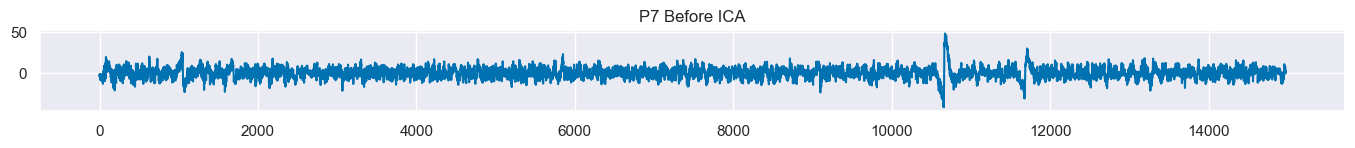

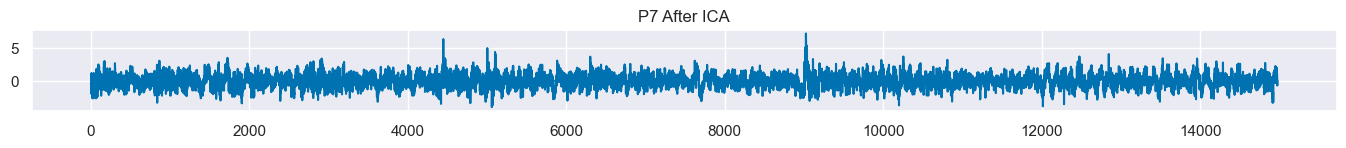

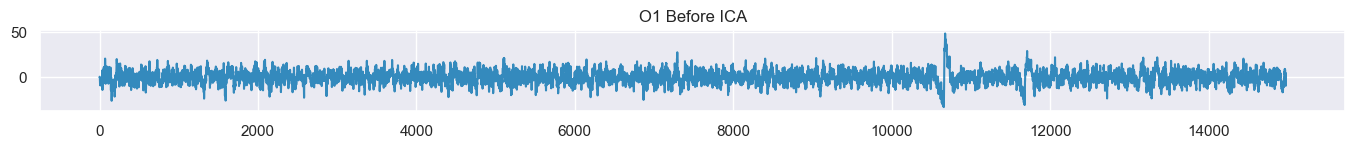

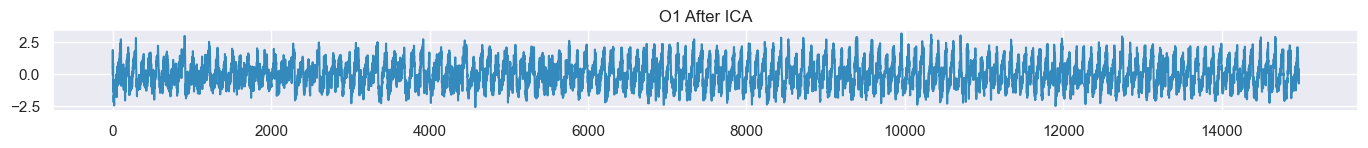

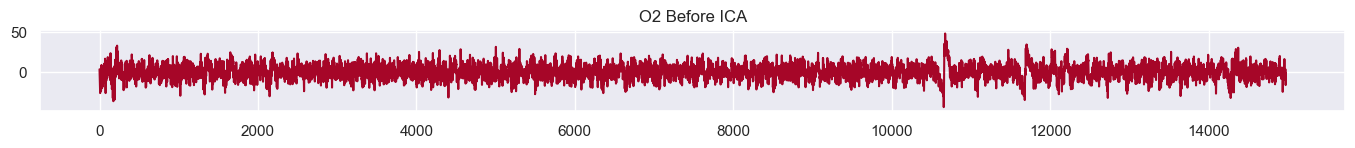

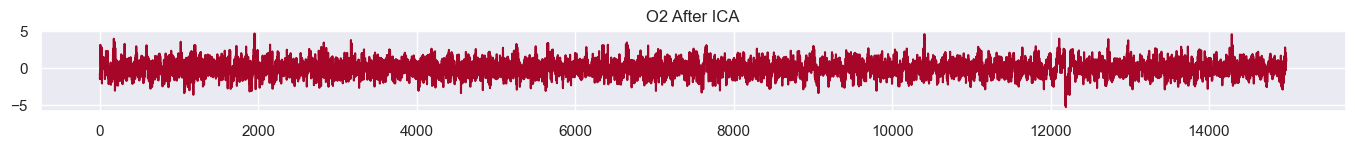

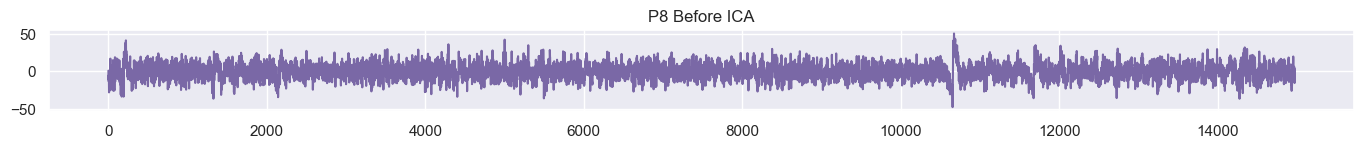

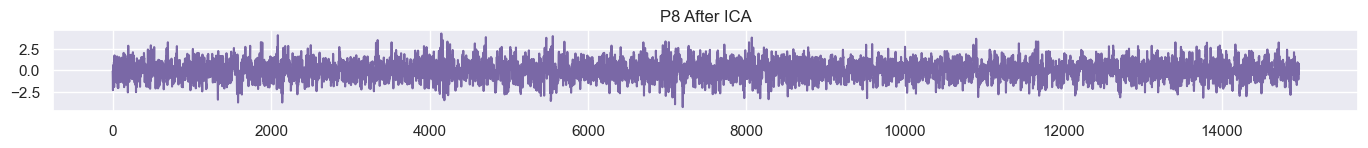

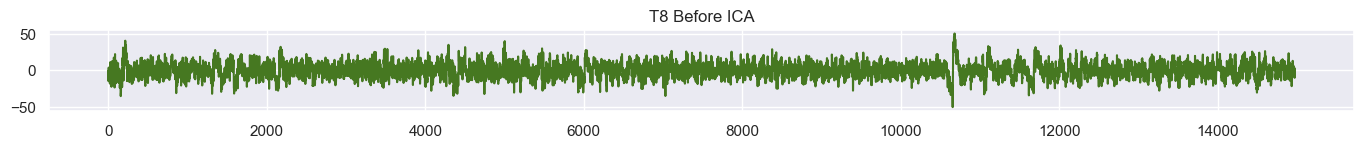

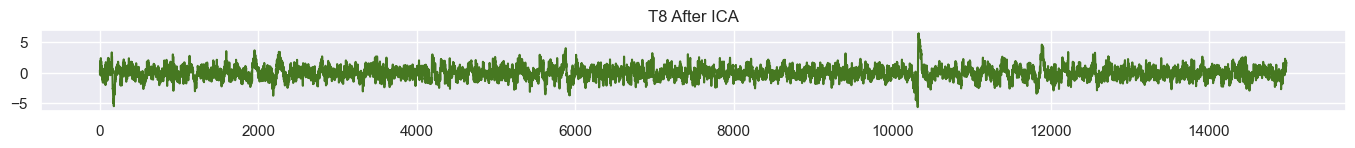

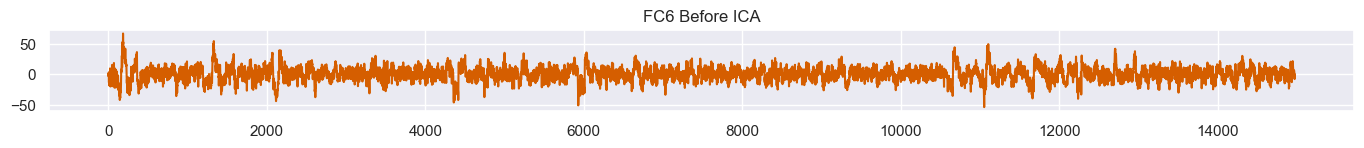

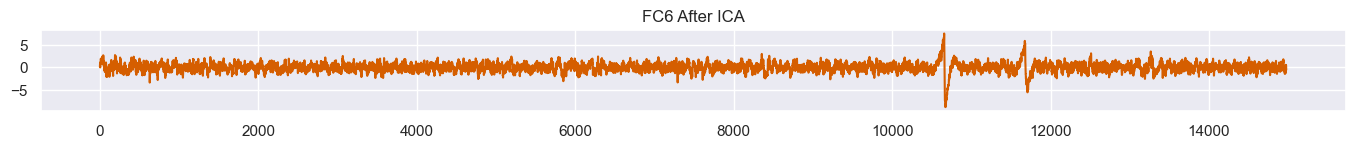

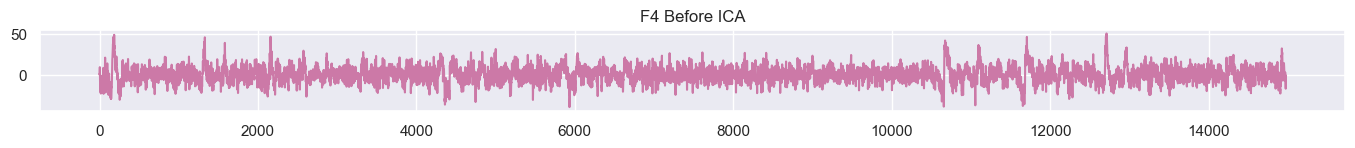

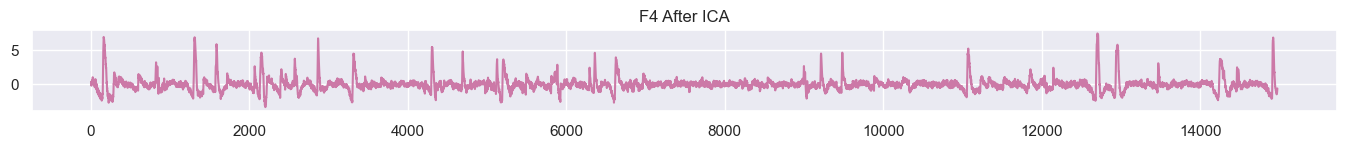

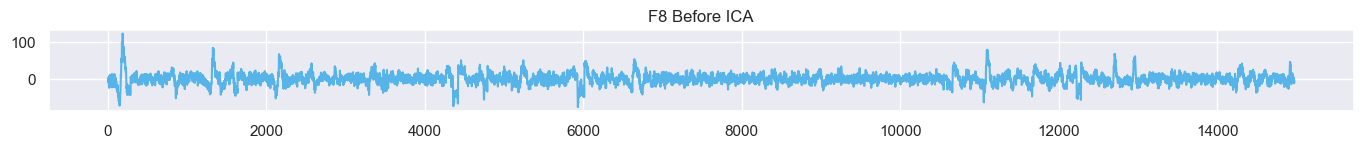

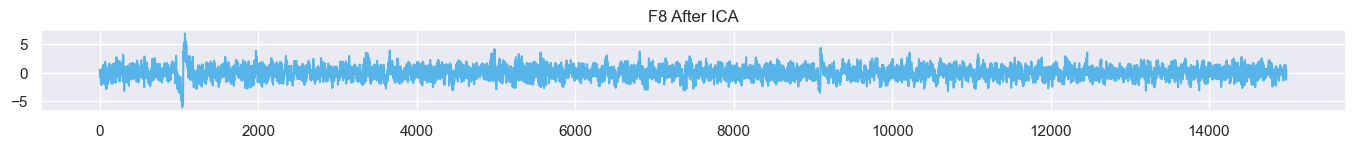

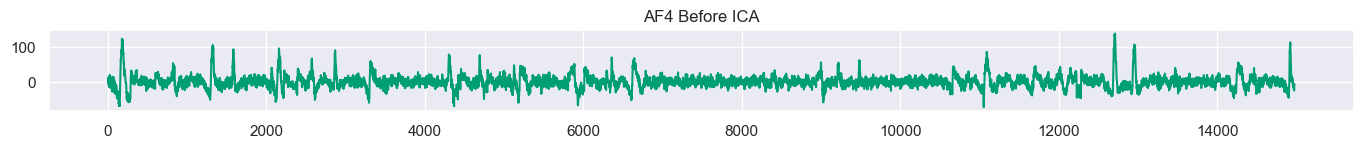

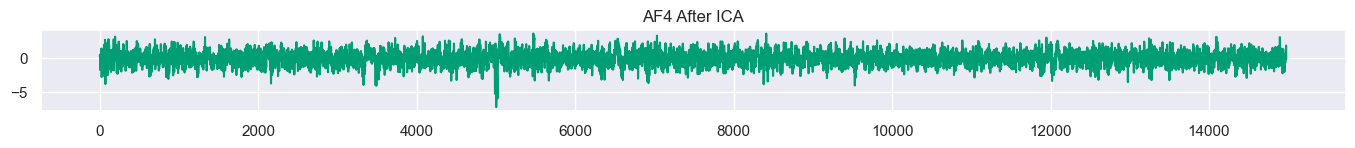

In [83]:
for feature in data_features:
   plot_difference(df_filtered_bandpass_car[feature], cleaned_eeg_data_ICA[feature] ,feature, 'ICA')

#### Moving Average Filter
* A Moving Average Filter is a signal processing technique used to smooth or attenuate high-frequency components in a time series or signal by calculating the average of data points within a moving window. It is commonly employed to reduce noise and highlight underlying trends or patterns.

* In the context of EEG data preprocessing, applying a Moving Average Filter can help enhance the visibility of relevant EEG signal patterns while minimizing the impact of high-frequency noise or artifacts.

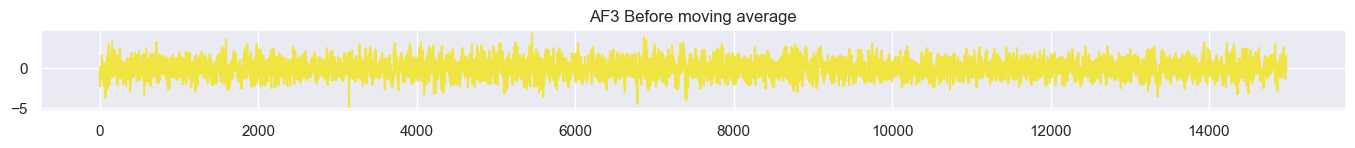

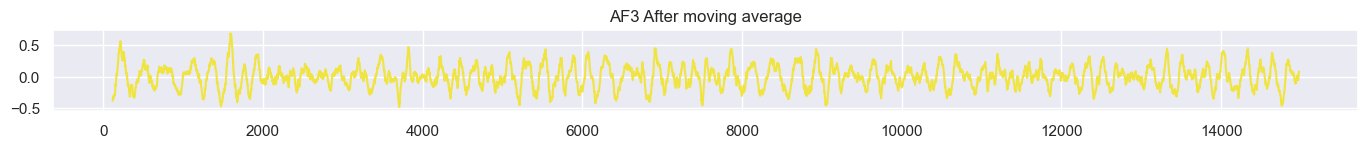

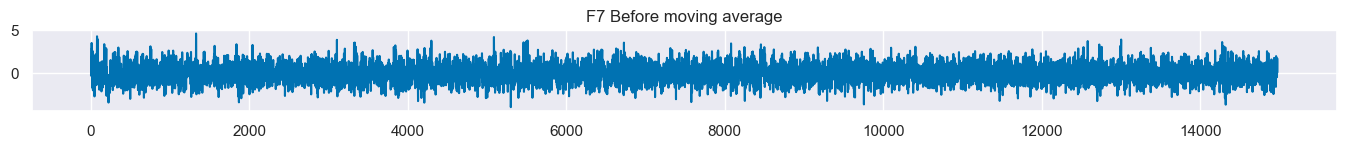

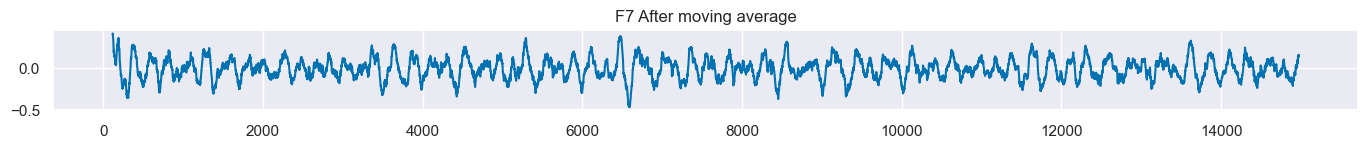

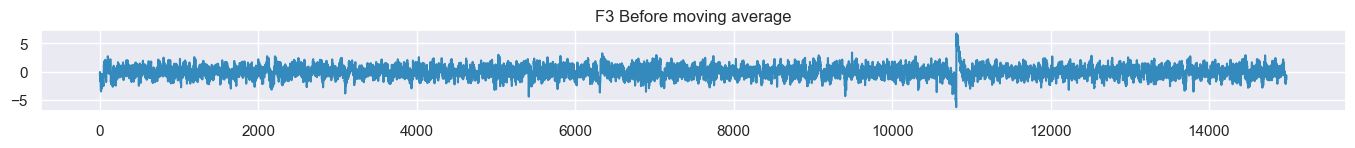

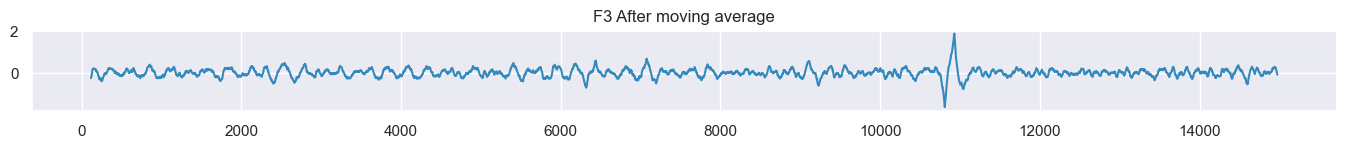

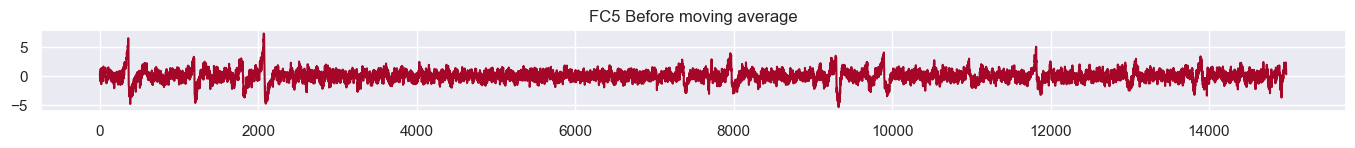

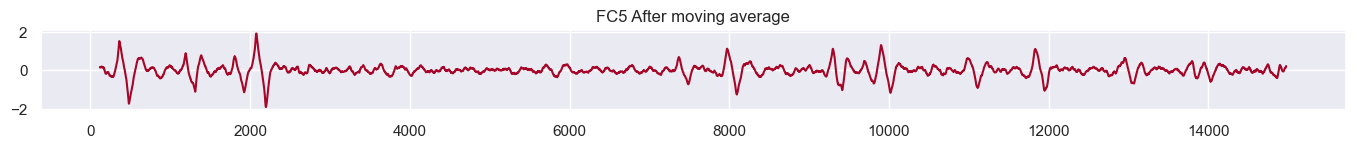

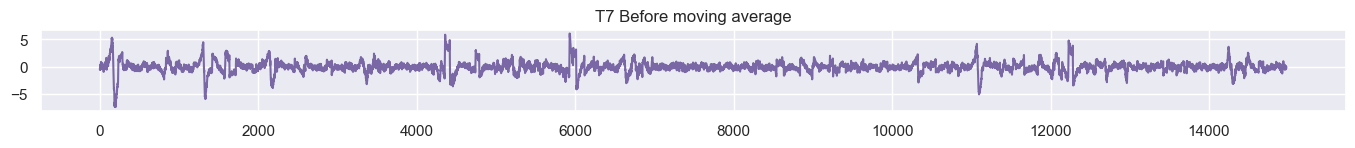

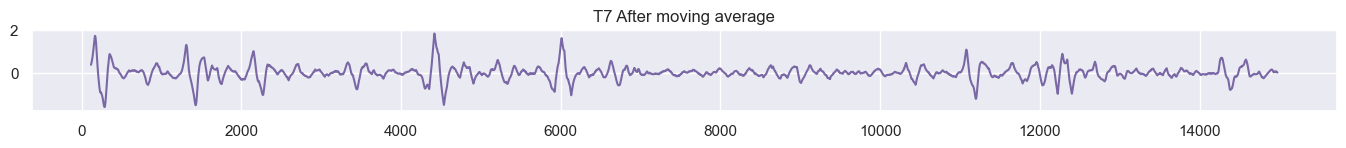

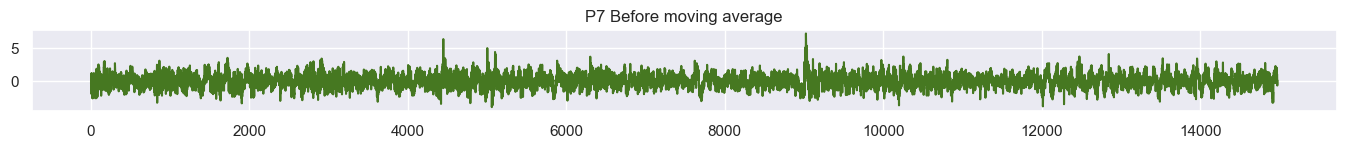

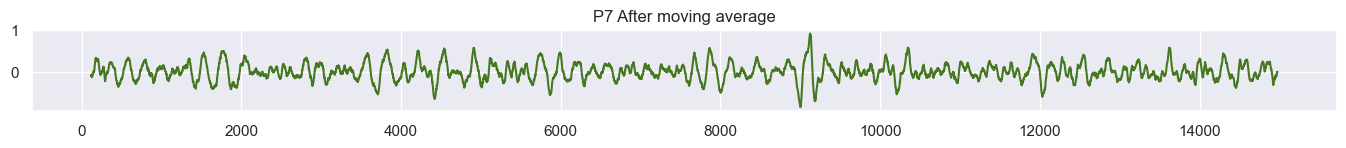

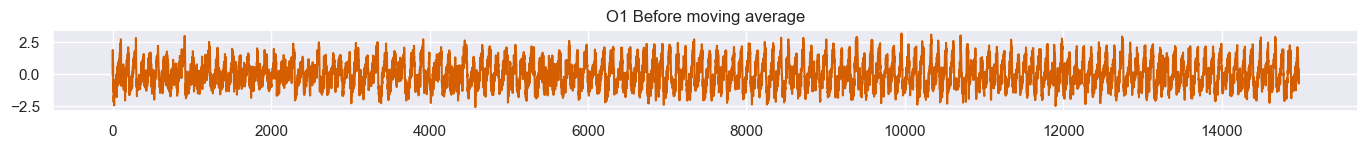

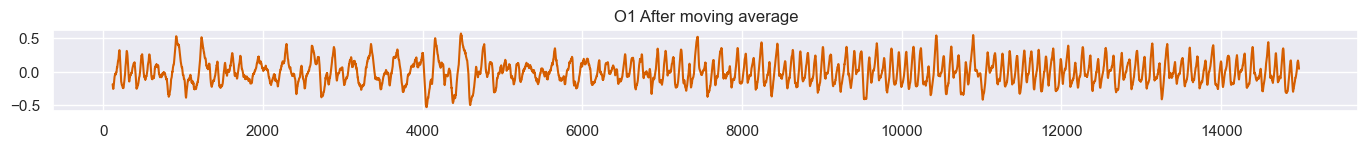

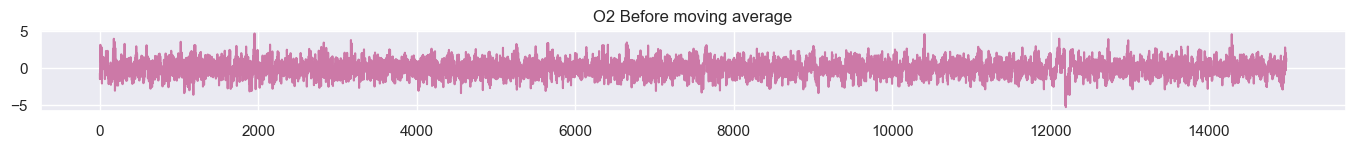

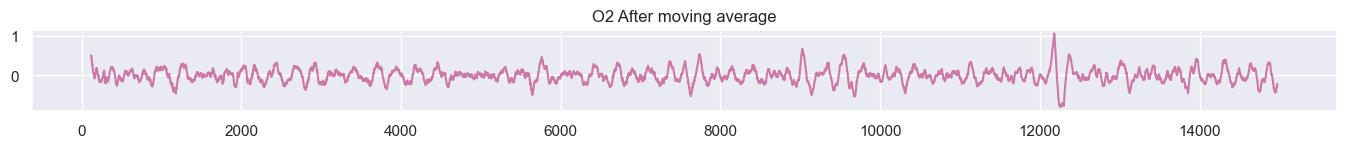

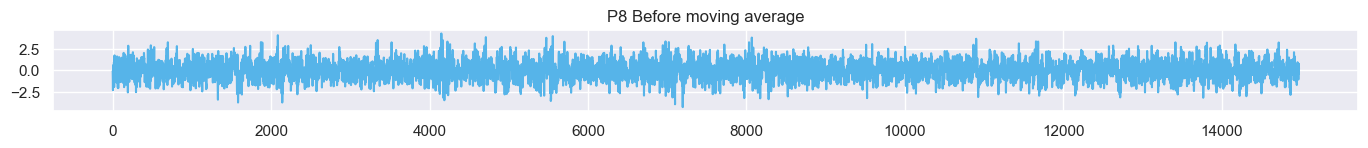

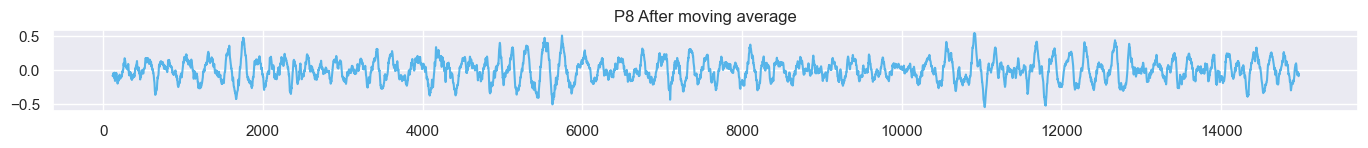

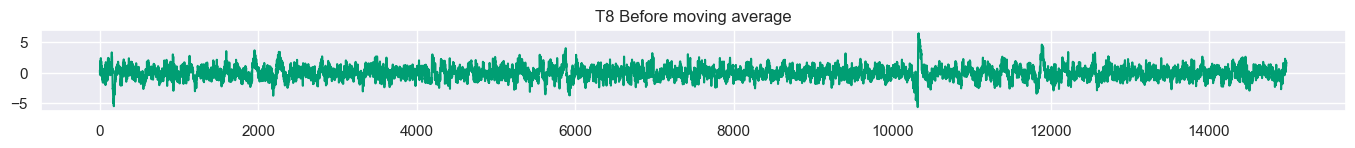

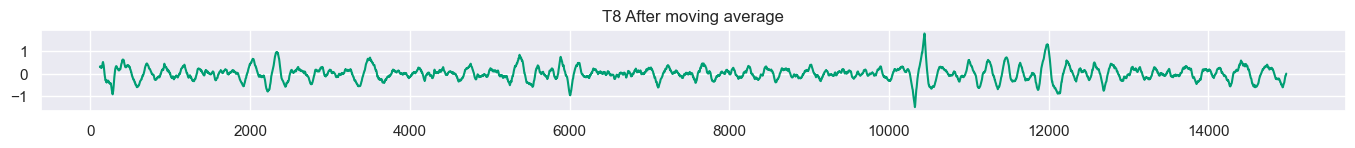

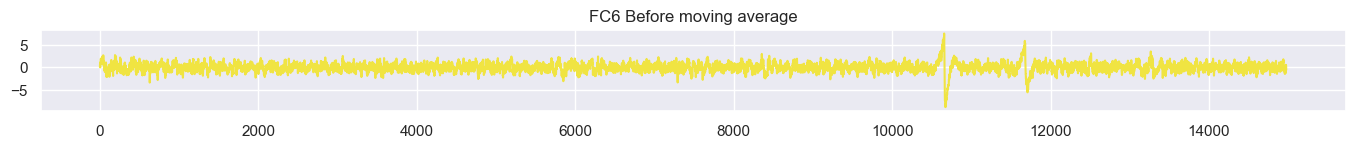

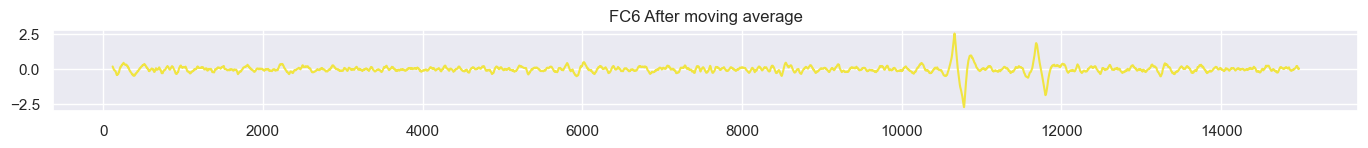

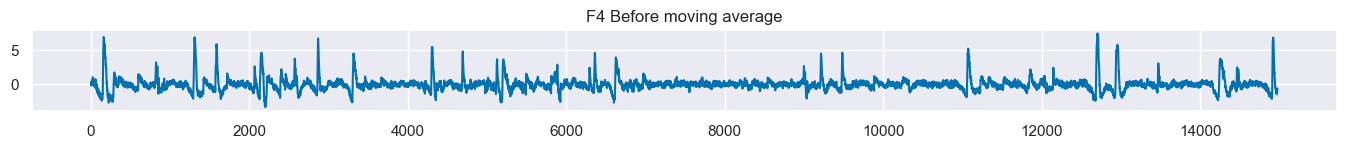

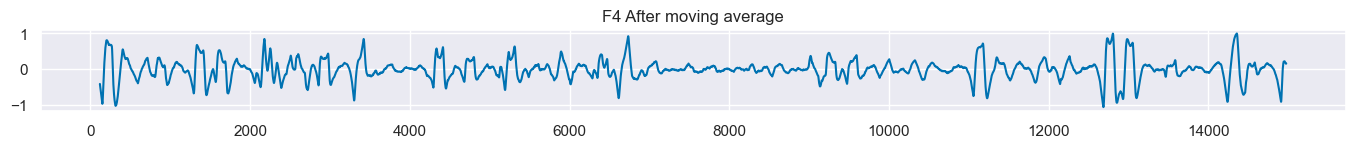

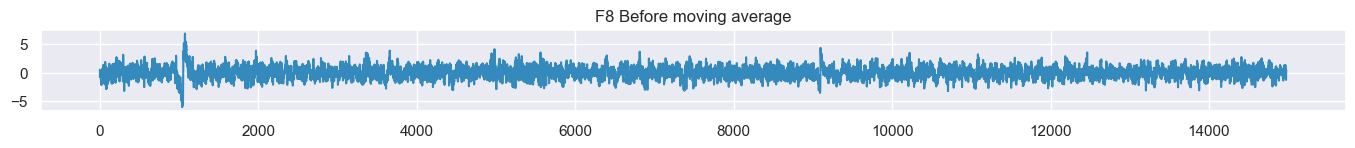

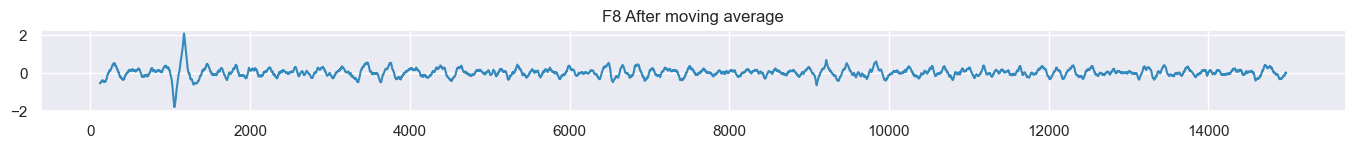

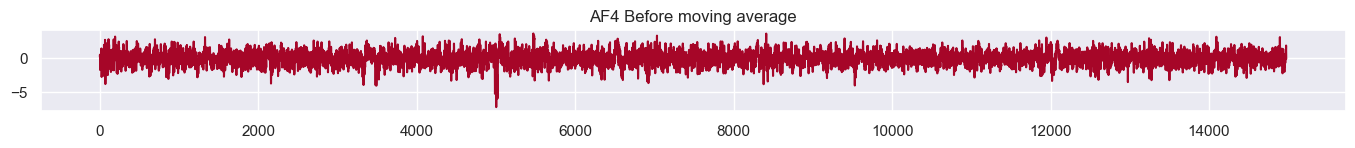

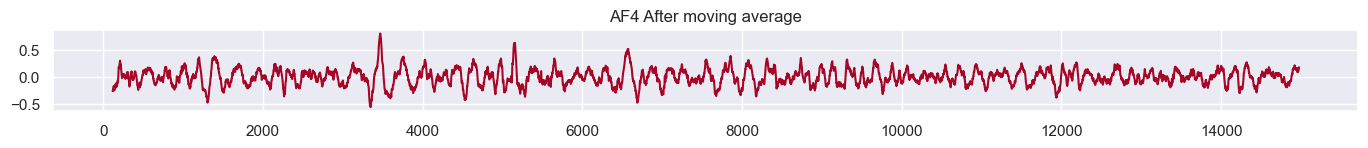

In [85]:
#  how many data points are included in each window
window_size = 120
# Create a copy of the original DataFrame
df_processed_with_MA = cleaned_eeg_data_ICA.copy()
df_moving_average = cleaned_eeg_data_ICA.copy()

# Apply the moving average to the specified features
for feature in data_features:
    # window is right-aligned with the current data point. In other words, the window covers the current data point and the previous window_size - 1 data points.
    df_processed_with_MA[feature] = df_moving_average[feature].rolling(window=window_size, center=False).mean()
    plot_difference( df_moving_average[feature],df_processed_with_MA[feature], feature, 'moving average')

In [86]:
df_processed_with_MA

AF3        F7        F3       FC5        T7        P7        O1  \
0           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
...         ...       ...       ...       ...       ...       ...       ...   
14971  0.021572  0.148324 -0.034663  0.203635  0.025391 -0.012168  0.092200   
14972  0.047649  0.147141 -0.036374  0.208985  0.026366 -0.016261  0.076616   
14973  0.068828  0.153326 -0.044317  0.215972  0.021997 -0.021015  0.063844   
14974  0.077941  0.158610 -0.067366  0.220554  0.014009 -0.019176  0.054975   
14975  0.078147  0.158474 -0.083995  0.217436  0.008285 -0.007614  0.044581   

             O2        P8        T8       FC6        F4        F8       AF4  \
0           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
...         ...       ...       ...       ...       ...       ...       ...   
14971 -0.264751 -0.080693 -0.051525  0.038373  0.156209 -0.014737  0.153127   
14972 -0.251201 -0.065776 -0.036822  0.048547  0.156288 -0.017416  0.170046   
14973 -0.238853 -0.053498 -0.025961  0.055627  0.156668 -0.021697  0.181523   
14974 -0.226294 -0.051952 -0.011439  0.056358  0.157777 -0.024779  0.179210   
14975 -0.213645 -0.054352 -0.004059  0.051472  0.159578 -0.023762  0.166908   

       eyeDetection  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
14971             1  
14972             1  
14973             1  
14974             1  
14975             1  

[14976 rows x 15 columns]

#### First 119 entries beecame NaN since window size is 120 (N-1)

In [87]:
check_entry = window_size
print(f'first {check_entry-1} entries becomes NaN')
df_processed_with_MA.iloc[check_entry-5 : check_entry+1]

first 119 entries becomes NaN


AF3        F7        F3       FC5        T7        P7        O1  \
115       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
116       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
117       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
118       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
119 -0.382098  0.422418 -0.249205  0.151128  0.375911 -0.094112 -0.186802   
120 -0.377708  0.424948 -0.229282  0.157230  0.389618 -0.087886 -0.192920   

           O2        P8        T8       FC6        F4        F8       AF4  \
115       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
116       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
117       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
118       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
119  0.498787 -0.080494  0.294488  0.195034 -0.408826 -0.571017 -0.255962   
120  0.496347 -0.085300  0.300076  0.176568 -0.427217 -0.566390 -0.253758   

     eyeDetection  
115             0  
116             0  
117             0  
118             0  
119             0  
120             0

In [88]:
# drop NaN
df_processed_with_MA = df_processed_with_MA.dropna()
df_processed_with_MA = df_processed_with_MA.reset_index(drop=True)
print(f"Dropped Values:{cleaned_eeg_data_ICA.shape[0] - df_processed_with_MA.shape[0]}")
print(f"shape before Moving Out {cleaned_eeg_data_ICA.shape}")
print(f"shape after Moving Out {df_processed_with_MA.shape}")

Dropped Values:119
shape before Moving Out (14976, 15)
shape after Moving Out (14857, 15)


In [89]:
df_processed_with_MA

AF3        F7        F3       FC5        T7        P7        O1  \
0     -0.382098  0.422418 -0.249205  0.151128  0.375911 -0.094112 -0.186802   
1     -0.377708  0.424948 -0.229282  0.157230  0.389618 -0.087886 -0.192920   
2     -0.362093  0.416181 -0.211326  0.154519  0.403999 -0.092299 -0.206397   
3     -0.339048  0.404168 -0.190990  0.149215  0.418725 -0.106940 -0.223874   
4     -0.324663  0.392574 -0.169761  0.149163  0.431997 -0.111559 -0.236512   
...         ...       ...       ...       ...       ...       ...       ...   
14852  0.021572  0.148324 -0.034663  0.203635  0.025391 -0.012168  0.092200   
14853  0.047649  0.147141 -0.036374  0.208985  0.026366 -0.016261  0.076616   
14854  0.068828  0.153326 -0.044317  0.215972  0.021997 -0.021015  0.063844   
14855  0.077941  0.158610 -0.067366  0.220554  0.014009 -0.019176  0.054975   
14856  0.078147  0.158474 -0.083995  0.217436  0.008285 -0.007614  0.044581   

             O2        P8        T8       FC6        F4        F8       AF4  \
0      0.498787 -0.080494  0.294488  0.195034 -0.408826 -0.571017 -0.255962   
1      0.496347 -0.085300  0.300076  0.176568 -0.427217 -0.566390 -0.253758   
2      0.501849 -0.087149  0.313490  0.153900 -0.444887 -0.563767 -0.260913   
3      0.502984 -0.083319  0.320166  0.133909 -0.463983 -0.559006 -0.262277   
4      0.492154 -0.073146  0.320224  0.121447 -0.483081 -0.550590 -0.243387   
...         ...       ...       ...       ...       ...       ...       ...   
14852 -0.264751 -0.080693 -0.051525  0.038373  0.156209 -0.014737  0.153127   
14853 -0.251201 -0.065776 -0.036822  0.048547  0.156288 -0.017416  0.170046   
14854 -0.238853 -0.053498 -0.025961  0.055627  0.156668 -0.021697  0.181523   
14855 -0.226294 -0.051952 -0.011439  0.056358  0.157777 -0.024779  0.179210   
14856 -0.213645 -0.054352 -0.004059  0.051472  0.159578 -0.023762  0.166908   

       eyeDetection  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
14852             1  
14853             1  
14854             1  
14855             1  
14856             1  

[14857 rows x 15 columns]

#### Correlation

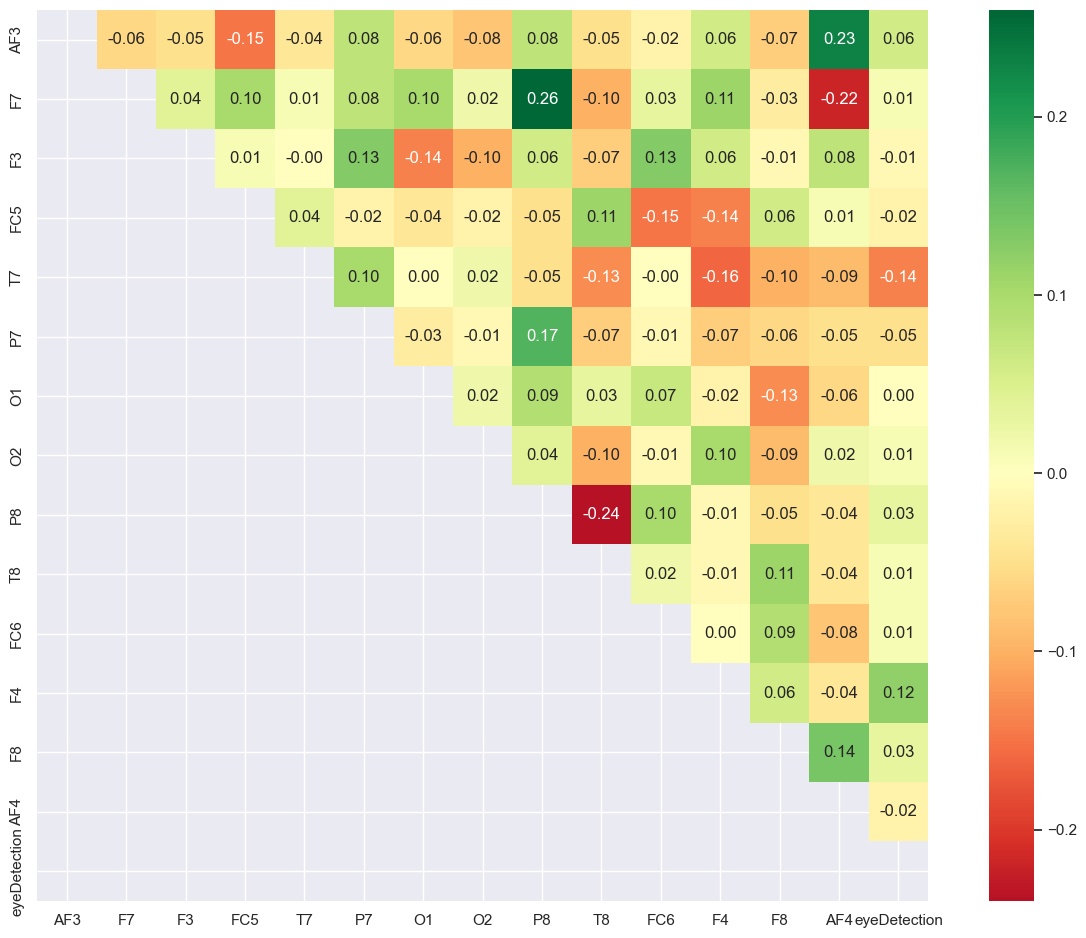

In [90]:
corr_matrix = df_processed_with_MA.corr().round(2)

# Create a mask
mask = np.tril(np.ones_like(corr_matrix, dtype=bool))

# Create a custom divergin palette
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center='light', as_cmap=True)

plt.figure(figsize=(14, 11))
sns.heatmap(corr_matrix, mask=mask, center=0, annot=True, 
            fmt='.2f', square=True, cmap='RdYlGn')
plt.show()

### Feature Extraction

In [108]:
df_new = df_processed_with_MA.copy()
#Time domain features
df_new['mean'] = df_new[data_features].mean(axis=1)
df_new['variance'] = df_new[data_features].var(axis=1)
df_new['skewness'] = df_new[data_features].skew(axis=1)
df_new['kurtosis'] = df_new[data_features].kurtosis(axis=1)
df_new['rms'] = np.sqrt(np.mean(df_new[data_features]**2, axis=1))
df_new

AF3        F7        F3       FC5        T7        P7        O1  \
0     -0.382098  0.422418 -0.249205  0.151128  0.375911 -0.094112 -0.186802   
1     -0.377708  0.424948 -0.229282  0.157230  0.389618 -0.087886 -0.192920   
2     -0.362093  0.416181 -0.211326  0.154519  0.403999 -0.092299 -0.206397   
3     -0.339048  0.404168 -0.190990  0.149215  0.418725 -0.106940 -0.223874   
4     -0.324663  0.392574 -0.169761  0.149163  0.431997 -0.111559 -0.236512   
...         ...       ...       ...       ...       ...       ...       ...   
14852  0.021572  0.148324 -0.034663  0.203635  0.025391 -0.012168  0.092200   
14853  0.047649  0.147141 -0.036374  0.208985  0.026366 -0.016261  0.076616   
14854  0.068828  0.153326 -0.044317  0.215972  0.021997 -0.021015  0.063844   
14855  0.077941  0.158610 -0.067366  0.220554  0.014009 -0.019176  0.054975   
14856  0.078147  0.158474 -0.083995  0.217436  0.008285 -0.007614  0.044581   

             O2        P8        T8       FC6        F4        F8       AF4  \
0      0.498787 -0.080494  0.294488  0.195034 -0.408826 -0.571017 -0.255962   
1      0.496347 -0.085300  0.300076  0.176568 -0.427217 -0.566390 -0.253758   
2      0.501849 -0.087149  0.313490  0.153900 -0.444887 -0.563767 -0.260913   
3      0.502984 -0.083319  0.320166  0.133909 -0.463983 -0.559006 -0.262277   
4      0.492154 -0.073146  0.320224  0.121447 -0.483081 -0.550590 -0.243387   
...         ...       ...       ...       ...       ...       ...       ...   
14852 -0.264751 -0.080693 -0.051525  0.038373  0.156209 -0.014737  0.153127   
14853 -0.251201 -0.065776 -0.036822  0.048547  0.156288 -0.017416  0.170046   
14854 -0.238853 -0.053498 -0.025961  0.055627  0.156668 -0.021697  0.181523   
14855 -0.226294 -0.051952 -0.011439  0.056358  0.157777 -0.024779  0.179210   
14856 -0.213645 -0.054352 -0.004059  0.051472  0.159578 -0.023762  0.166908   

       eyeDetection      mean  variance  skewness  kurtosis       rms  
0                 0 -0.020768  0.117473  0.075440 -1.294860  0.330928  
1                 0 -0.019691  0.118032  0.077228 -1.291745  0.331646  
2                 0 -0.020350  0.118972  0.098289 -1.276266  0.332998  
3                 0 -0.021448  0.118802  0.116525 -1.248252  0.332830  
4                 0 -0.020367  0.116954  0.096718 -1.216575  0.330174  
...             ...       ...       ...       ...       ...       ...  
14852             1  0.027164  0.014838 -0.759172  1.265824  0.120483  
14853             1  0.032699  0.014274 -0.694534  1.191502  0.119682  
14854             1  0.036603  0.014211 -0.561694  0.870563  0.120565  
14855             1  0.037030  0.014126 -0.424758  0.450099  0.120368  
14856             1  0.035532  0.013473 -0.352394  0.207471  0.117358  

[14857 rows x 20 columns]

In [109]:
bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 100)  # Adjust upper limit as needed
}

# Initialize a dictionary to store band power ratios
band_power_ratios = {}

# Loop through each channel in your data
for channel in df_new.columns[:-3]:  # Exclude non-EEG columns

    # Compute the PSD for the channel
    f, Pxx = welch(df_new[channel], fs=128)  

    # Initialize a dictionary to store band powers
    channel_band_powers = {}
    
    # Calculate band powers
    for band, (low, high) in bands.items():
        band_mask = (f >= low) & (f <= high)
        band_power = np.trapz(Pxx[band_mask], f[band_mask])
        channel_band_powers[band] = band_power

    # Calculate band power ratios
    ratios = {
        'Theta/Delta': channel_band_powers['Theta'] / channel_band_powers['Delta'],
        'Alpha/Theta': channel_band_powers['Alpha'] / channel_band_powers['Theta'],
        'Beta/Alpha': channel_band_powers['Beta'] / channel_band_powers['Alpha'],
        'Gamma/Beta': channel_band_powers['Gamma'] / channel_band_powers['Beta'],
    }

    band_power_ratios[channel] = ratios

# You can now use band_power_ratios dictionary to access the ratios for each channel

In [110]:
# Create a new DataFrame to store the band power ratios
band_power_ratios_df = pd.DataFrame(band_power_ratios).T

# Reset the index so that the channel names become a column
band_power_ratios_df.reset_index(inplace=True)
band_power_ratios_df.rename(columns={'index': 'Channel'}, inplace=True)
band_power_ratios_df

Channel  Theta/Delta  Alpha/Theta  Beta/Alpha  Gamma/Beta
0            AF3     0.013030     0.467185    0.416078    0.073708
1             F7     0.016846     0.566024    0.922915    0.132104
2             F3     0.010392     0.239700    0.597161    0.111535
3            FC5     0.002111     0.252679    0.634466    0.187397
4             T7     0.001616     0.183043    0.364807    0.085910
5             P7     0.004830     0.390231    0.905152    0.152660
6             O1     0.006915     0.153418    0.533378    0.112348
7             O2     0.009480     0.464623    0.712047    0.091387
8             P8     0.018164     0.329797    0.559206    0.062982
9             T8     0.004568     0.244672    0.489671    0.129178
10           FC6     0.004589     0.240931    0.384333    0.082016
11            F4     0.002369     0.088255    0.282834    0.086922
12            F8     0.006061     0.423430    0.598507    0.093579
13           AF4     0.014842     0.701835    0.332772    0.082915
14  eyeDetection     0.056345     0.385144    0.968684    0.576919
15          mean     0.006603     0.361568    0.476870    0.089337
16      variance     0.008563     0.126237    0.399248    0.105318

## Classification

In [111]:
# Split the data into features (X) and labels (y)
X = df_new.drop('eyeDetection',axis=1)  # Features (excluding the last three columns)
y = df_new['eyeDetection']  # Labels (assuming 'eyeDetection' is the target variable)
X


AF3        F7        F3       FC5        T7        P7        O1  \
0     -0.382098  0.422418 -0.249205  0.151128  0.375911 -0.094112 -0.186802   
1     -0.377708  0.424948 -0.229282  0.157230  0.389618 -0.087886 -0.192920   
2     -0.362093  0.416181 -0.211326  0.154519  0.403999 -0.092299 -0.206397   
3     -0.339048  0.404168 -0.190990  0.149215  0.418725 -0.106940 -0.223874   
4     -0.324663  0.392574 -0.169761  0.149163  0.431997 -0.111559 -0.236512   
...         ...       ...       ...       ...       ...       ...       ...   
14852  0.021572  0.148324 -0.034663  0.203635  0.025391 -0.012168  0.092200   
14853  0.047649  0.147141 -0.036374  0.208985  0.026366 -0.016261  0.076616   
14854  0.068828  0.153326 -0.044317  0.215972  0.021997 -0.021015  0.063844   
14855  0.077941  0.158610 -0.067366  0.220554  0.014009 -0.019176  0.054975   
14856  0.078147  0.158474 -0.083995  0.217436  0.008285 -0.007614  0.044581   

             O2        P8        T8       FC6        F4        F8       AF4  \
0      0.498787 -0.080494  0.294488  0.195034 -0.408826 -0.571017 -0.255962   
1      0.496347 -0.085300  0.300076  0.176568 -0.427217 -0.566390 -0.253758   
2      0.501849 -0.087149  0.313490  0.153900 -0.444887 -0.563767 -0.260913   
3      0.502984 -0.083319  0.320166  0.133909 -0.463983 -0.559006 -0.262277   
4      0.492154 -0.073146  0.320224  0.121447 -0.483081 -0.550590 -0.243387   
...         ...       ...       ...       ...       ...       ...       ...   
14852 -0.264751 -0.080693 -0.051525  0.038373  0.156209 -0.014737  0.153127   
14853 -0.251201 -0.065776 -0.036822  0.048547  0.156288 -0.017416  0.170046   
14854 -0.238853 -0.053498 -0.025961  0.055627  0.156668 -0.021697  0.181523   
14855 -0.226294 -0.051952 -0.011439  0.056358  0.157777 -0.024779  0.179210   
14856 -0.213645 -0.054352 -0.004059  0.051472  0.159578 -0.023762  0.166908   

           mean  variance  skewness  kurtosis       rms  
0     -0.020768  0.117473  0.075440 -1.294860  0.330928  
1     -0.019691  0.118032  0.077228 -1.291745  0.331646  
2     -0.020350  0.118972  0.098289 -1.276266  0.332998  
3     -0.021448  0.118802  0.116525 -1.248252  0.332830  
4     -0.020367  0.116954  0.096718 -1.216575  0.330174  
...         ...       ...       ...       ...       ...  
14852  0.027164  0.014838 -0.759172  1.265824  0.120483  
14853  0.032699  0.014274 -0.694534  1.191502  0.119682  
14854  0.036603  0.014211 -0.561694  0.870563  0.120565  
14855  0.037030  0.014126 -0.424758  0.450099  0.120368  
14856  0.035532  0.013473 -0.352394  0.207471  0.117358  

[14857 rows x 19 columns]

In [112]:
y

0        0
1        0
2        0
3        0
4        0
        ..
14852    1
14853    1
14854    1
14855    1
14856    1
Name: eyeDetection, Length: 14857, dtype: int64

In [113]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=48, test_size=0.2, stratify=y, shuffle=True)

In [118]:
print(colored("Shapes of our variables", "green", attrs=['bold', 'underline']))
print(colored(f"\tX_train: {X_train.shape[0]} rows for {X_train.shape[1]} columns", "green"))
print(colored(f"\tX_test: {X_test.shape[0]} rows for {X_test.shape[1]} columns", "green"))
print(colored(f"\ty_train: {y_train.shape[0]} rows for {1} columns", "green"))
print(colored(f"\ty_test: {y_test.shape[0]} rows for {1} columns", "green"))

Shapes of our variables
	X_train: 11885 rows for 19 columns
	X_test: 2972 rows for 19 columns
	y_train: 11885 rows for 1 columns
	y_test: 2972 rows for 1 columns


## Random Forest Classifier
* In a random forest classification, multiple decision trees are created using different random subsets of the data and features. Each decision tree is like an expert, providing its opinion on how to classify the data. Predictions are made by calculating the prediction for each decision tree, then taking the most popular result. (For regression, predictions use an averaging technique instead.)

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


# Create a Random Forest classifier with L2 regularization (controlled by max_depth)
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)  # You can adjust max_depth for regularization

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate and print the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print a classification report with precision, recall, and F1-score
print(classification_report(y_test, y_pred))

Accuracy: 0.6988559892328399
              precision    recall  f1-score   support

           0       0.65      0.98      0.78      1627
           1       0.94      0.36      0.52      1345

    accuracy                           0.70      2972
   macro avg       0.79      0.67      0.65      2972
weighted avg       0.78      0.70      0.66      2972



In [115]:

# Normalize the data 
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

Accuracy: 0.6968371467025573
              precision    recall  f1-score   support

           0       0.65      0.98      0.78      1627
           1       0.94      0.35      0.51      1345

    accuracy                           0.70      2972
   macro avg       0.79      0.67      0.65      2972
weighted avg       0.78      0.70      0.66      2972



## Decision Tree Classifier
* Decision trees are a popular machine learning algorithm used for both classification and regression tasks. They recursively split the dataset based on feature conditions, creating a tree-like structure of decisions. At each node, the algorithm selects the feature that best separates the data, considering criteria such as Gini impurity or information gain. This process continues until a stopping criterion is met, such as a maximum depth or a node containing samples from a single class. Decision trees are interpretable, easy to visualize, and can capture complex relationships in the data.

In [119]:
dct = DecisionTreeClassifier()
dct.fit(X_train, y_train)
y_pred = dct.predict(X_test)
accuracy_score(y_test, y_pred)


0.974764468371467

In [120]:
dct = DecisionTreeClassifier()
dct.fit(X_train_norm, y_train)
y_pred = dct.predict(X_test_norm)
accuracy_score(y_test, y_pred)


0.9724091520861373

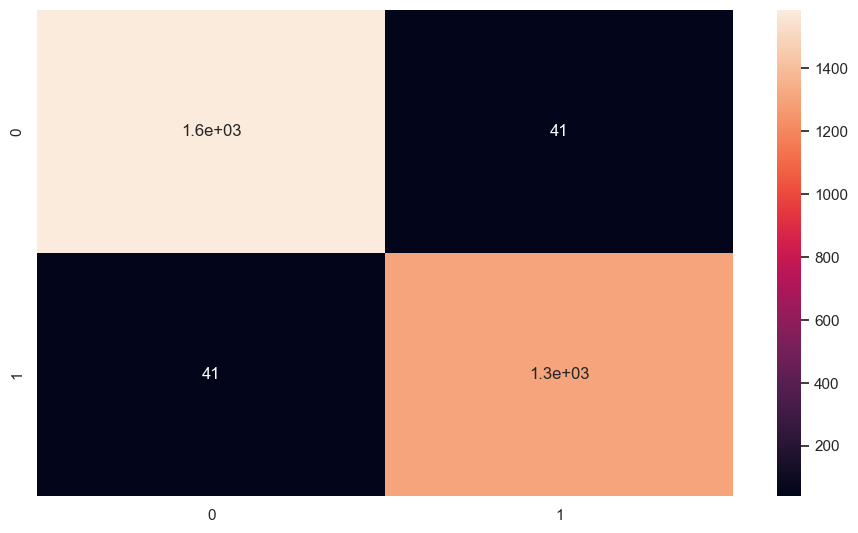

In [121]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True)
plt.show()

### StratifiedKFold with the  Decision Tree Classifier

In [124]:
# Create a Decision Tree Classifier
dct = DecisionTreeClassifier()

# Define the cross-validation strategy (Stratified K-Fold is suitable for classification)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(dct, X_train, y_train, cv=cv, scoring='accuracy')

# Print the accuracy scores for each fold
print("Cross-Validation Accuracy Scores:", scores)

# Print the mean and standard deviation of the scores
print("Mean Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())

Cross-Validation Accuracy Scores: [0.95666807 0.96424064 0.96003366 0.95624737 0.96297854]
Mean Accuracy: 0.960033655868742
Standard Deviation: 0.003225963737935331


## SVM

In [125]:
# Create and train SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train_norm, y_train)

# Make predictions
y_pred_svm = svm_classifier.predict(X_test_norm)

# Evaluate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm}")

SVM Accuracy: 0.5945491251682369


## K-Nearest Neighbors
* The k-nearest neighbors algorithm, also known as KNN or k-NN, is a non-parametric, supervised learning classifier, which uses proximity to make classifications or predictions about the grouping of an individual data point. While it can be used for either regression or classification problems, it is typically used as a classification algorithm, working off the assumption that similar points can be found near one another.

In [126]:
from sklearn.neighbors import KNeighborsClassifier

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred_knn = knn_classifier.predict(X_test_scaled)

# Evaluate accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"k-NN Accuracy: {accuracy_knn}")

k-NN Accuracy: 0.9973082099596231


#### Stratified K Fold Cross Validation for KNN


In [127]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create and configure the k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Initialize StratifiedKFold
stratkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store accuracy scores
accuracy_scores = []

# Perform stratified k-fold cross-validation
for train_index, test_index in stratkf.split(X_scaled, y):
    X_train_new, X_test_new = X_scaled[train_index], X_scaled[test_index]
    y_train_new, y_test_new = y[train_index], y[test_index]

    # Train the model
    knn_classifier.fit(X_train_new, y_train_new)

    # Make predictions
    y_pred_new = knn_classifier.predict(X_test_new)

    # Evaluate accuracy and store the score
    accuracy = accuracy_score(y_test_new, y_pred_new)
    accuracy_scores.append(accuracy)

# Display the average accuracy across all folds
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Average Accuracy: {average_accuracy}")

Average Accuracy: 0.9979133417563137


In [128]:

# Create a K-Nearest Neighbors Classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors as needed

# Define the cross-validation strategy (Stratified K-Fold is suitable for classification)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(knn, X_scaled, y, cv=cv, scoring='accuracy')

# Print the accuracy scores for each fold
print("Cross-Validation Accuracy Scores:", scores)

# Print the mean and standard deviation of the scores
print("Mean Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())


Cross-Validation Accuracy Scores: [0.99899058 0.99831763 0.99764389 0.99663413 0.99798048]
Mean Accuracy: 0.9979133417563137
Standard Deviation: 0.000779407904252595


#### Confusion matrix and heat map for KNN

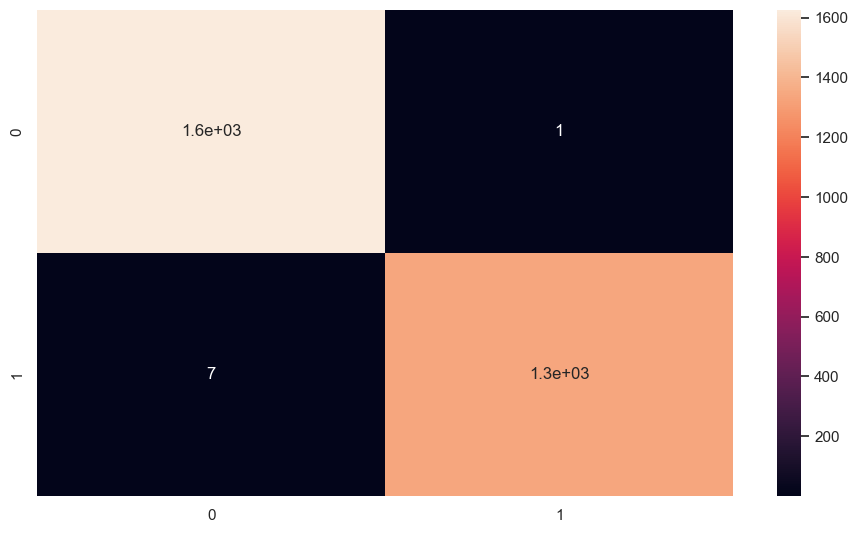

In [130]:
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True)
plt.show()


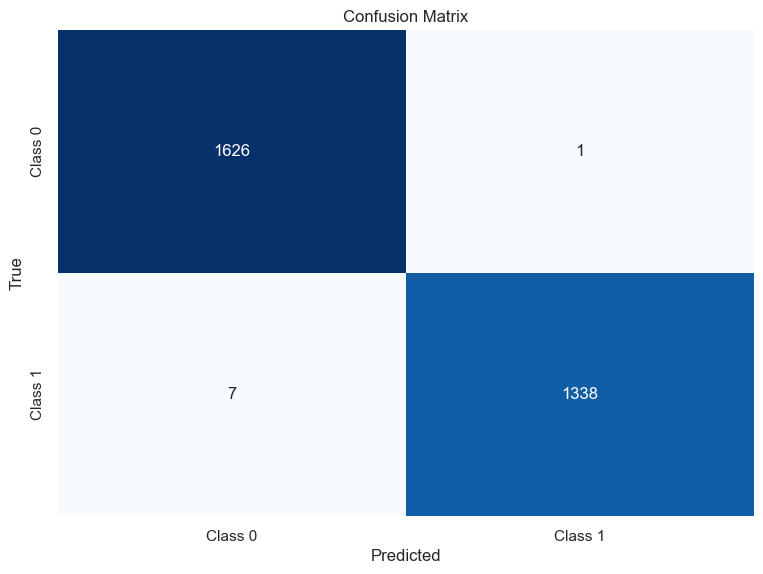

In [135]:
# Assuming y_pred and y_test are NumPy arrays or lists
conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()